In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import datetime
import time

%matplotlib inline

In [2]:
data = pd.read_csv("../dataset/T1.csv")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [4]:
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [5]:
data.isnull().sum()


Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [6]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'],format="%d %m %Y %H:%M")


In [7]:
data['Year'] = data['Date/Time'].dt.year
data['Month'] = data['Date/Time'].dt.month
data['Day'] = data['Date/Time'].dt.day
data['Time_Hours'] = data['Date/Time'].dt.hour
data['Time_Minutes'] = data['Date/Time'].dt.minute

In [8]:
data.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Year', 'Month',
       'Day', 'Time_Hours', 'Time_Minutes'],
      dtype='object')

In [9]:
cols = [ 'Year', 'Month', "Day", "Time_Hours", "Time_Minutes" ]
data = data.drop(cols, axis=1)
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [10]:
df = data.copy()

# Building LSTM 

In [11]:



from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [12]:
# converting the Data/Time as the index for proper shape of the input.
df = df.set_index('Date/Time')

In [13]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 15
neurons_exp = 10
predict_values_exp = 10000
lag_exp=24

In [14]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [15]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [16]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [17]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [18]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [19]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = tf.keras.models.Sequential()
    
    # Use LSTM layer with CuDNN backend if available
    if tf.test.is_gpu_available(cuda_only=True):
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    else:
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, implementation=2))
    
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    
    # Print model summary after training
    print(model.summary())
    
    return model

In [20]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [21]:
df.columns

Index(['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [22]:
'''Drop all the features as we will not be having any in production'''
del df['LV ActivePower (kW)']
del df['Theoretical_Power_Curve (KWh)']
del df['Wind Speed (m/s)']
df.head()

,Wind Direction (°)
Date/Time,
2018-01-01 00:00:00,259.994904
2018-01-01 00:10:00,268.641113
2018-01-01 00:20:00,272.564789
2018-01-01 00:30:00,271.258087
2018-01-01 00:40:00,265.674286


In [23]:
for i in range(0,10):
  df = df[:-1]
df.tail()

,Wind Direction (°)
Date/Time,
2018-12-31 21:30:00,79.699562
2018-12-31 21:40:00,80.132507
2018-12-31 21:50:00,80.081612
2018-12-31 22:00:00,80.452248
2018-12-31 22:10:00,80.960693


In [24]:
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [25]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [26]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [27]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [28]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


40519/40519 [==============================] - 126s 3ms/step - loss: 0.0102
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   1400      
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [29]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 1s 900ms/step
Hour=1, Predicted=61.890801, Expected=70.988777
1/1 [==============================] - 0s 40ms/step
Hour=2, Predicted=66.098362, Expected=63.711590
1/1 [==============================] - 0s 24ms/step
Hour=3, Predicted=58.666615, Expected=59.588829
1/1 [==============================] - 0s 32ms/step
Hour=4, Predicted=56.287603, Expected=70.990387
1/1 [==============================] - 0s 41ms/step
Hour=5, Predicted=64.370113, Expected=68.981422
1/1 [==============================] - 0s 24ms/step
Hour=6, Predicted=65.364287, Expected=72.413963
1/1 [==============================] - 0s 16ms/step
Hour=7, Predicted=71.794612, Expected=85.495758
1/1 [==============================] - 0s 24ms/step
Hour=8, Predicted=81.207232, Expected=104.586502
1/1 [==============================] - 0s 24ms/step
Hour=9, Predicted=101.204240, Expected=125.075501
1/1 [==============================] - 0s 16ms/step
Hour=10, Predicted=124.079627, Expected=78.7

1/1 [==============================] - 0s 67ms/step
Hour=82, Predicted=53.390496, Expected=50.655121
1/1 [==============================] - 0s 153ms/step
Hour=83, Predicted=49.184491, Expected=37.679260
1/1 [==============================] - 0s 47ms/step
Hour=84, Predicted=36.208302, Expected=22.296761
1/1 [==============================] - 0s 48ms/step
Hour=85, Predicted=20.827022, Expected=54.297001
1/1 [==============================] - 0s 28ms/step
Hour=86, Predicted=52.826731, Expected=68.498833
1/1 [==============================] - 0s 31ms/step
Hour=87, Predicted=67.027498, Expected=63.347790
1/1 [==============================] - 0s 32ms/step
Hour=88, Predicted=61.877746, Expected=70.593208
1/1 [==============================] - 0s 39ms/step
Hour=89, Predicted=69.123158, Expected=78.852097
1/1 [==============================] - 0s 44ms/step
Hour=90, Predicted=77.380872, Expected=63.978748
1/1 [==============================] - 0s 49ms/step
Hour=91, Predicted=62.508030, Expected

1/1 [==============================] - 0s 24ms/step
Hour=163, Predicted=69.597240, Expected=69.286346
1/1 [==============================] - 0s 24ms/step
Hour=164, Predicted=67.815723, Expected=59.837662
1/1 [==============================] - 0s 21ms/step
Hour=165, Predicted=58.367037, Expected=55.656639
1/1 [==============================] - 0s 24ms/step
Hour=166, Predicted=54.186013, Expected=52.393421
1/1 [==============================] - 0s 16ms/step
Hour=167, Predicted=50.922795, Expected=50.798409
1/1 [==============================] - 0s 24ms/step
Hour=168, Predicted=49.327785, Expected=50.529190
1/1 [==============================] - 0s 16ms/step
Hour=169, Predicted=49.058566, Expected=51.247921
1/1 [==============================] - 0s 24ms/step
Hour=170, Predicted=49.777297, Expected=52.347950
1/1 [==============================] - 0s 16ms/step
Hour=171, Predicted=50.877323, Expected=54.329281
1/1 [==============================] - 0s 24ms/step
Hour=172, Predicted=52.858656,

1/1 [==============================] - 0s 24ms/step
Hour=244, Predicted=23.807416, Expected=21.753620
1/1 [==============================] - 0s 16ms/step
Hour=245, Predicted=20.282996, Expected=16.380951
1/1 [==============================] - 0s 32ms/step
Hour=246, Predicted=14.910325, Expected=19.617590
1/1 [==============================] - 0s 40ms/step
Hour=247, Predicted=18.146964, Expected=13.677310
1/1 [==============================] - 0s 24ms/step
Hour=248, Predicted=12.206686, Expected=16.213209
1/1 [==============================] - 0s 24ms/step
Hour=249, Predicted=14.742585, Expected=9.672971
1/1 [==============================] - 0s 40ms/step
Hour=250, Predicted=8.202346, Expected=19.677620
1/1 [==============================] - 0s 24ms/step
Hour=251, Predicted=18.206996, Expected=18.769409
1/1 [==============================] - 0s 25ms/step
Hour=252, Predicted=17.298785, Expected=16.841049
1/1 [==============================] - 0s 40ms/step
Hour=253, Predicted=15.370423, E

1/1 [==============================] - 0s 16ms/step
Hour=324, Predicted=54.137366, Expected=51.021431
1/1 [==============================] - 0s 24ms/step
Hour=325, Predicted=49.550807, Expected=49.964809
1/1 [==============================] - 0s 24ms/step
Hour=326, Predicted=48.494184, Expected=50.444450
1/1 [==============================] - 0s 24ms/step
Hour=327, Predicted=48.973825, Expected=53.956249
1/1 [==============================] - 0s 24ms/step
Hour=328, Predicted=52.485625, Expected=53.440609
1/1 [==============================] - 0s 23ms/step
Hour=329, Predicted=51.969985, Expected=53.160530
1/1 [==============================] - 0s 32ms/step
Hour=330, Predicted=51.689906, Expected=50.727360
1/1 [==============================] - 0s 24ms/step
Hour=331, Predicted=49.256735, Expected=56.257240
1/1 [==============================] - 0s 23ms/step
Hour=332, Predicted=54.786615, Expected=49.991100
1/1 [==============================] - 0s 24ms/step
Hour=333, Predicted=48.520475,

1/1 [==============================] - 0s 32ms/step
Hour=404, Predicted=58.237246, Expected=61.206711
1/1 [==============================] - 0s 24ms/step
Hour=405, Predicted=59.736086, Expected=59.813869
1/1 [==============================] - 0s 16ms/step
Hour=406, Predicted=58.343245, Expected=58.888939
1/1 [==============================] - 0s 16ms/step
Hour=407, Predicted=57.418315, Expected=57.659592
1/1 [==============================] - 0s 24ms/step
Hour=408, Predicted=56.188967, Expected=56.048752
1/1 [==============================] - 0s 16ms/step
Hour=409, Predicted=54.578126, Expected=42.029202
1/1 [==============================] - 0s 16ms/step
Hour=410, Predicted=40.558577, Expected=37.704910
1/1 [==============================] - 0s 16ms/step
Hour=411, Predicted=36.234286, Expected=36.978291
1/1 [==============================] - 0s 24ms/step
Hour=412, Predicted=35.507666, Expected=33.442760
1/1 [==============================] - 0s 32ms/step
Hour=413, Predicted=31.972136,

1/1 [==============================] - 0s 24ms/step
Hour=484, Predicted=68.698198, Expected=70.076134
1/1 [==============================] - 0s 32ms/step
Hour=485, Predicted=68.605509, Expected=71.004112
1/1 [==============================] - 0s 32ms/step
Hour=486, Predicted=69.533488, Expected=70.518784
1/1 [==============================] - 0s 24ms/step
Hour=487, Predicted=69.048159, Expected=68.684959
1/1 [==============================] - 0s 24ms/step
Hour=488, Predicted=67.214334, Expected=68.760658
1/1 [==============================] - 0s 24ms/step
Hour=489, Predicted=67.290034, Expected=65.986832
1/1 [==============================] - 0s 24ms/step
Hour=490, Predicted=64.516207, Expected=68.674713
1/1 [==============================] - 0s 24ms/step
Hour=491, Predicted=67.204089, Expected=68.177010
1/1 [==============================] - 0s 32ms/step
Hour=492, Predicted=66.706385, Expected=68.722198
1/1 [==============================] - 0s 32ms/step
Hour=493, Predicted=67.251574,

1/1 [==============================] - 0s 16ms/step
Hour=564, Predicted=68.513224, Expected=71.352341
1/1 [==============================] - 0s 24ms/step
Hour=565, Predicted=69.881716, Expected=70.115608
1/1 [==============================] - 0s 24ms/step
Hour=566, Predicted=68.644984, Expected=63.917049
1/1 [==============================] - 0s 16ms/step
Hour=567, Predicted=62.446425, Expected=50.862461
1/1 [==============================] - 0s 24ms/step
Hour=568, Predicted=49.391837, Expected=54.062408
1/1 [==============================] - 0s 25ms/step
Hour=569, Predicted=52.591784, Expected=49.565960
1/1 [==============================] - 0s 24ms/step
Hour=570, Predicted=48.095336, Expected=54.191681
1/1 [==============================] - 0s 24ms/step
Hour=571, Predicted=52.721055, Expected=50.420528
1/1 [==============================] - 0s 16ms/step
Hour=572, Predicted=48.949904, Expected=51.800591
1/1 [==============================] - 0s 32ms/step
Hour=573, Predicted=50.329966,

1/1 [==============================] - 0s 24ms/step
Hour=643, Predicted=202.424868, Expected=203.899399
1/1 [==============================] - 0s 24ms/step
Hour=644, Predicted=202.428774, Expected=200.038895
1/1 [==============================] - 0s 24ms/step
Hour=645, Predicted=198.568269, Expected=204.822998
1/1 [==============================] - 0s 16ms/step
Hour=646, Predicted=203.352374, Expected=206.843994
1/1 [==============================] - 0s 24ms/step
Hour=647, Predicted=205.373370, Expected=210.333496
1/1 [==============================] - 0s 16ms/step
Hour=648, Predicted=208.862872, Expected=212.953507
1/1 [==============================] - 0s 19ms/step
Hour=649, Predicted=211.482882, Expected=212.562805
1/1 [==============================] - 0s 24ms/step
Hour=650, Predicted=211.092181, Expected=215.054596
1/1 [==============================] - 0s 16ms/step
Hour=651, Predicted=213.583972, Expected=215.585205
1/1 [==============================] - 0s 21ms/step
Hour=652, Pr

1/1 [==============================] - 0s 24ms/step
Hour=722, Predicted=271.021775, Expected=269.614197
1/1 [==============================] - 0s 24ms/step
Hour=723, Predicted=268.143571, Expected=268.983002
1/1 [==============================] - 0s 16ms/step
Hour=724, Predicted=267.512377, Expected=266.502808
1/1 [==============================] - 0s 24ms/step
Hour=725, Predicted=265.032183, Expected=266.007202
1/1 [==============================] - 0s 16ms/step
Hour=726, Predicted=264.536578, Expected=263.722992
1/1 [==============================] - 0s 16ms/step
Hour=727, Predicted=262.252368, Expected=270.396301
1/1 [==============================] - 0s 24ms/step
Hour=728, Predicted=268.925677, Expected=267.621796
1/1 [==============================] - 0s 32ms/step
Hour=729, Predicted=266.151171, Expected=262.313812
1/1 [==============================] - 0s 24ms/step
Hour=730, Predicted=260.843188, Expected=262.769287
1/1 [==============================] - 0s 16ms/step
Hour=731, Pr

1/1 [==============================] - 0s 24ms/step
Hour=801, Predicted=329.066485, Expected=339.366211
1/1 [==============================] - 0s 18ms/step
Hour=802, Predicted=337.895587, Expected=338.850403
1/1 [==============================] - 0s 24ms/step
Hour=803, Predicted=337.379777, Expected=350.315796
1/1 [==============================] - 0s 32ms/step
Hour=804, Predicted=348.845172, Expected=349.710510
1/1 [==============================] - 0s 32ms/step
Hour=805, Predicted=348.239886, Expected=345.795898
1/1 [==============================] - 0s 32ms/step
Hour=806, Predicted=344.325274, Expected=357.279205
1/1 [==============================] - 0s 24ms/step
Hour=807, Predicted=355.808581, Expected=12.170860
1/1 [==============================] - 0s 40ms/step
Hour=808, Predicted=10.700236, Expected=358.132294
1/1 [==============================] - 0s 39ms/step
Hour=809, Predicted=356.661669, Expected=342.839813
1/1 [==============================] - 0s 56ms/step
Hour=810, Pred

1/1 [==============================] - 0s 24ms/step
Hour=881, Predicted=-0.988341, Expected=2.849479
1/1 [==============================] - 0s 24ms/step
Hour=882, Predicted=1.378855, Expected=353.380402
1/1 [==============================] - 0s 24ms/step
Hour=883, Predicted=351.909777, Expected=350.883301
1/1 [==============================] - 0s 41ms/step
Hour=884, Predicted=349.412675, Expected=350.146301
1/1 [==============================] - 0s 24ms/step
Hour=885, Predicted=348.675677, Expected=348.585510
1/1 [==============================] - 0s 24ms/step
Hour=886, Predicted=347.114886, Expected=339.676605
1/1 [==============================] - 0s 32ms/step
Hour=887, Predicted=338.205981, Expected=335.420502
1/1 [==============================] - 0s 24ms/step
Hour=888, Predicted=333.949877, Expected=327.229706
1/1 [==============================] - 0s 24ms/step
Hour=889, Predicted=325.759081, Expected=313.351715
1/1 [==============================] - 0s 24ms/step
Hour=890, Predict

1/1 [==============================] - 0s 32ms/step
Hour=960, Predicted=212.551074, Expected=211.117798
1/1 [==============================] - 0s 32ms/step
Hour=961, Predicted=209.647174, Expected=209.650207
1/1 [==============================] - 0s 24ms/step
Hour=962, Predicted=208.179583, Expected=214.706497
1/1 [==============================] - 0s 24ms/step
Hour=963, Predicted=213.235873, Expected=213.819199
1/1 [==============================] - 0s 32ms/step
Hour=964, Predicted=212.348574, Expected=214.190796
1/1 [==============================] - 0s 28ms/step
Hour=965, Predicted=212.720172, Expected=214.650604
1/1 [==============================] - 0s 40ms/step
Hour=966, Predicted=213.179980, Expected=212.418198
1/1 [==============================] - 0s 24ms/step
Hour=967, Predicted=210.947573, Expected=210.716904
1/1 [==============================] - 0s 34ms/step
Hour=968, Predicted=209.246279, Expected=213.483200
1/1 [==============================] - 0s 24ms/step
Hour=969, Pr

1/1 [==============================] - 0s 37ms/step
Hour=1038, Predicted=187.701373, Expected=191.333206
1/1 [==============================] - 0s 16ms/step
Hour=1039, Predicted=189.862582, Expected=193.223206
1/1 [==============================] - 0s 24ms/step
Hour=1040, Predicted=191.752581, Expected=193.750397
1/1 [==============================] - 0s 24ms/step
Hour=1041, Predicted=192.279771, Expected=195.552399
1/1 [==============================] - 0s 24ms/step
Hour=1042, Predicted=194.081773, Expected=197.495193
1/1 [==============================] - 0s 40ms/step
Hour=1043, Predicted=196.024569, Expected=198.107605
1/1 [==============================] - 0s 24ms/step
Hour=1044, Predicted=196.636981, Expected=196.808701
1/1 [==============================] - 0s 24ms/step
Hour=1045, Predicted=195.338075, Expected=197.066803
1/1 [==============================] - 0s 24ms/step
Hour=1046, Predicted=195.596179, Expected=196.968796
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=1116, Predicted=181.709872, Expected=184.142303
1/1 [==============================] - 0s 24ms/step
Hour=1117, Predicted=182.671678, Expected=187.070999
1/1 [==============================] - 0s 24ms/step
Hour=1118, Predicted=185.600375, Expected=188.054306
1/1 [==============================] - 0s 24ms/step
Hour=1119, Predicted=186.583682, Expected=190.170197
1/1 [==============================] - 0s 24ms/step
Hour=1120, Predicted=188.699572, Expected=192.302505
1/1 [==============================] - 0s 24ms/step
Hour=1121, Predicted=190.831881, Expected=189.429199
1/1 [==============================] - 0s 24ms/step
Hour=1122, Predicted=187.958575, Expected=190.378799
1/1 [==============================] - 0s 24ms/step
Hour=1123, Predicted=188.908175, Expected=188.381103
1/1 [==============================] - 0s 24ms/step
Hour=1124, Predicted=186.910478, Expected=187.000900
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=1194, Predicted=195.702777, Expected=197.190597
1/1 [==============================] - 0s 32ms/step
Hour=1195, Predicted=195.719973, Expected=199.906204
1/1 [==============================] - 0s 24ms/step
Hour=1196, Predicted=198.435578, Expected=202.460297
1/1 [==============================] - 0s 32ms/step
Hour=1197, Predicted=200.989672, Expected=200.043701
1/1 [==============================] - 0s 24ms/step
Hour=1198, Predicted=198.573077, Expected=199.332596
1/1 [==============================] - 0s 16ms/step
Hour=1199, Predicted=197.861971, Expected=198.884995
1/1 [==============================] - 0s 40ms/step
Hour=1200, Predicted=197.414370, Expected=198.269608
1/1 [==============================] - 0s 32ms/step
Hour=1201, Predicted=196.798983, Expected=199.221497
1/1 [==============================] - 0s 32ms/step
Hour=1202, Predicted=197.750871, Expected=202.416107
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=1272, Predicted=183.472872, Expected=182.821899
1/1 [==============================] - 0s 24ms/step
Hour=1273, Predicted=181.351275, Expected=187.376602
1/1 [==============================] - 0s 16ms/step
Hour=1274, Predicted=185.905978, Expected=190.780395
1/1 [==============================] - 0s 20ms/step
Hour=1275, Predicted=189.309771, Expected=191.994904
1/1 [==============================] - 0s 24ms/step
Hour=1276, Predicted=190.524279, Expected=190.381699
1/1 [==============================] - 0s 24ms/step
Hour=1277, Predicted=188.911074, Expected=195.732193
1/1 [==============================] - 0s 16ms/step
Hour=1278, Predicted=194.261569, Expected=188.502106
1/1 [==============================] - 0s 16ms/step
Hour=1279, Predicted=187.031480, Expected=200.739502
1/1 [==============================] - 0s 24ms/step
Hour=1280, Predicted=199.268876, Expected=200.819504
1/1 [==============================] - 0s 28ms/step
Hou

1/1 [==============================] - 0s 28ms/step
Hour=1350, Predicted=231.179171, Expected=231.040802
1/1 [==============================] - 0s 32ms/step
Hour=1351, Predicted=229.570178, Expected=227.882400
1/1 [==============================] - 0s 32ms/step
Hour=1352, Predicted=226.411777, Expected=223.701508
1/1 [==============================] - 0s 32ms/step
Hour=1353, Predicted=222.230883, Expected=221.929001
1/1 [==============================] - 0s 24ms/step
Hour=1354, Predicted=220.458377, Expected=217.862595
1/1 [==============================] - 0s 32ms/step
Hour=1355, Predicted=216.391970, Expected=212.902802
1/1 [==============================] - 0s 24ms/step
Hour=1356, Predicted=211.432177, Expected=209.823105
1/1 [==============================] - 0s 40ms/step
Hour=1357, Predicted=208.352481, Expected=207.527405
1/1 [==============================] - 0s 24ms/step
Hour=1358, Predicted=206.056780, Expected=199.179001
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 25ms/step
Hour=1428, Predicted=209.273074, Expected=211.598099
1/1 [==============================] - 0s 33ms/step
Hour=1429, Predicted=210.127473, Expected=206.387100
1/1 [==============================] - 0s 24ms/step
Hour=1430, Predicted=204.916476, Expected=204.326202
1/1 [==============================] - 0s 24ms/step
Hour=1431, Predicted=202.855578, Expected=203.860001
1/1 [==============================] - 0s 32ms/step
Hour=1432, Predicted=202.389376, Expected=199.691101
1/1 [==============================] - 0s 25ms/step
Hour=1433, Predicted=198.220477, Expected=201.634598
1/1 [==============================] - 0s 40ms/step
Hour=1434, Predicted=200.163972, Expected=210.054306
1/1 [==============================] - 0s 32ms/step
Hour=1435, Predicted=208.583682, Expected=209.436996
1/1 [==============================] - 0s 56ms/step
Hour=1436, Predicted=207.966371, Expected=210.207306
1/1 [==============================] - 0s 49ms/step
Hou

1/1 [==============================] - 0s 16ms/step
Hour=1506, Predicted=177.728182, Expected=179.471893
1/1 [==============================] - 0s 24ms/step
Hour=1507, Predicted=178.001269, Expected=179.568802
1/1 [==============================] - 0s 24ms/step
Hour=1508, Predicted=178.098176, Expected=172.849793
1/1 [==============================] - 0s 24ms/step
Hour=1509, Predicted=171.379167, Expected=174.177597
1/1 [==============================] - 0s 24ms/step
Hour=1510, Predicted=172.706973, Expected=181.085998
1/1 [==============================] - 0s 16ms/step
Hour=1511, Predicted=179.615374, Expected=183.851502
1/1 [==============================] - 0s 16ms/step
Hour=1512, Predicted=182.380877, Expected=185.064407
1/1 [==============================] - 0s 20ms/step
Hour=1513, Predicted=183.593783, Expected=192.873001
1/1 [==============================] - 0s 24ms/step
Hour=1514, Predicted=191.402377, Expected=170.385895
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=1584, Predicted=211.021777, Expected=211.392105
1/1 [==============================] - 0s 24ms/step
Hour=1585, Predicted=209.921479, Expected=211.161407
1/1 [==============================] - 0s 24ms/step
Hour=1586, Predicted=209.690783, Expected=211.334000
1/1 [==============================] - 0s 24ms/step
Hour=1587, Predicted=209.863375, Expected=209.641495
1/1 [==============================] - 0s 32ms/step
Hour=1588, Predicted=208.170870, Expected=209.106400
1/1 [==============================] - 0s 20ms/step
Hour=1589, Predicted=207.635775, Expected=210.818298
1/1 [==============================] - 0s 24ms/step
Hour=1590, Predicted=209.347673, Expected=213.210800
1/1 [==============================] - 0s 24ms/step
Hour=1591, Predicted=211.740174, Expected=210.736893
1/1 [==============================] - 0s 24ms/step
Hour=1592, Predicted=209.266268, Expected=207.820297
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 34ms/step
Hour=1662, Predicted=209.751574, Expected=220.434601
1/1 [==============================] - 0s 32ms/step
Hour=1663, Predicted=218.963976, Expected=230.237106
1/1 [==============================] - 0s 24ms/step
Hour=1664, Predicted=228.766481, Expected=231.442398
1/1 [==============================] - 0s 28ms/step
Hour=1665, Predicted=229.971774, Expected=251.198593
1/1 [==============================] - 0s 41ms/step
Hour=1666, Predicted=249.727969, Expected=246.046295
1/1 [==============================] - 0s 40ms/step
Hour=1667, Predicted=244.575671, Expected=233.786606
1/1 [==============================] - 0s 56ms/step
Hour=1668, Predicted=232.315981, Expected=208.552200
1/1 [==============================] - 0s 24ms/step
Hour=1669, Predicted=207.081576, Expected=210.367004
1/1 [==============================] - 0s 24ms/step
Hour=1670, Predicted=208.896379, Expected=224.853897
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=1740, Predicted=-0.647581, Expected=357.397705
1/1 [==============================] - 0s 24ms/step
Hour=1741, Predicted=355.927081, Expected=353.203095
1/1 [==============================] - 0s 24ms/step
Hour=1742, Predicted=351.732470, Expected=356.826202
1/1 [==============================] - 0s 24ms/step
Hour=1743, Predicted=355.355578, Expected=20.320190
1/1 [==============================] - 0s 24ms/step
Hour=1744, Predicted=18.849566, Expected=24.926790
1/1 [==============================] - 0s 28ms/step
Hour=1745, Predicted=23.456166, Expected=46.889530
1/1 [==============================] - 0s 16ms/step
Hour=1746, Predicted=45.418906, Expected=36.308250
1/1 [==============================] - 0s 20ms/step
Hour=1747, Predicted=34.837625, Expected=39.901218
1/1 [==============================] - 0s 16ms/step
Hour=1748, Predicted=38.430594, Expected=25.720961
1/1 [==============================] - 0s 17ms/step
Hour=1749, Pred

Hour=1819, Predicted=66.492159, Expected=73.288544
1/1 [==============================] - 0s 17ms/step
Hour=1820, Predicted=71.817919, Expected=75.658127
1/1 [==============================] - 0s 17ms/step
Hour=1821, Predicted=74.187501, Expected=75.900139
1/1 [==============================] - 0s 22ms/step
Hour=1822, Predicted=74.429514, Expected=75.371429
1/1 [==============================] - 0s 24ms/step
Hour=1823, Predicted=73.900805, Expected=75.376312
1/1 [==============================] - 0s 24ms/step
Hour=1824, Predicted=73.905688, Expected=76.129677
1/1 [==============================] - 0s 24ms/step
Hour=1825, Predicted=74.659052, Expected=74.621147
1/1 [==============================] - 0s 17ms/step
Hour=1826, Predicted=73.150523, Expected=75.654472
1/1 [==============================] - 0s 23ms/step
Hour=1827, Predicted=74.183848, Expected=75.568314
1/1 [==============================] - 0s 32ms/step
Hour=1828, Predicted=74.097688, Expected=76.000816
1/1 [=================

1/1 [==============================] - 0s 16ms/step
Hour=1899, Predicted=90.746133, Expected=78.656151
1/1 [==============================] - 0s 16ms/step
Hour=1900, Predicted=77.185526, Expected=84.944862
1/1 [==============================] - 0s 24ms/step
Hour=1901, Predicted=83.474238, Expected=87.186577
1/1 [==============================] - 0s 16ms/step
Hour=1902, Predicted=85.715952, Expected=89.081467
1/1 [==============================] - 0s 22ms/step
Hour=1903, Predicted=87.610842, Expected=95.528000
1/1 [==============================] - 0s 16ms/step
Hour=1904, Predicted=94.057375, Expected=96.103340
1/1 [==============================] - 0s 16ms/step
Hour=1905, Predicted=94.632716, Expected=74.941841
1/1 [==============================] - 0s 24ms/step
Hour=1906, Predicted=73.471217, Expected=69.051987
1/1 [==============================] - 0s 16ms/step
Hour=1907, Predicted=67.581362, Expected=68.140648
1/1 [==============================] - 0s 40ms/step
Hour=1908, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=1979, Predicted=77.220353, Expected=77.060791
1/1 [==============================] - 0s 24ms/step
Hour=1980, Predicted=75.590167, Expected=76.037567
1/1 [==============================] - 0s 24ms/step
Hour=1981, Predicted=74.566943, Expected=78.783119
1/1 [==============================] - 0s 24ms/step
Hour=1982, Predicted=77.312495, Expected=75.055809
1/1 [==============================] - 0s 17ms/step
Hour=1983, Predicted=73.585185, Expected=69.822884
1/1 [==============================] - 0s 24ms/step
Hour=1984, Predicted=68.352259, Expected=71.848084
1/1 [==============================] - 0s 18ms/step
Hour=1985, Predicted=70.377459, Expected=72.635529
1/1 [==============================] - 0s 21ms/step
Hour=1986, Predicted=71.164904, Expected=71.977348
1/1 [==============================] - 0s 24ms/step
Hour=1987, Predicted=70.506724, Expected=67.880661
1/1 [==============================] - 0s 24ms/step
Hour=1988, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=2059, Predicted=65.008738, Expected=63.895142
1/1 [==============================] - 0s 24ms/step
Hour=2060, Predicted=62.424516, Expected=62.629749
1/1 [==============================] - 0s 23ms/step
Hour=2061, Predicted=61.159125, Expected=59.808800
1/1 [==============================] - 0s 24ms/step
Hour=2062, Predicted=58.338175, Expected=58.934360
1/1 [==============================] - 0s 22ms/step
Hour=2063, Predicted=57.463736, Expected=58.815720
1/1 [==============================] - 0s 24ms/step
Hour=2064, Predicted=57.345095, Expected=60.117592
1/1 [==============================] - 0s 23ms/step
Hour=2065, Predicted=58.646967, Expected=60.898380
1/1 [==============================] - 0s 24ms/step
Hour=2066, Predicted=59.427755, Expected=60.368061
1/1 [==============================] - 0s 16ms/step
Hour=2067, Predicted=58.897435, Expected=58.617409
1/1 [==============================] - 0s 17ms/step
Hour=2068, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=2139, Predicted=46.953795, Expected=54.754539
1/1 [==============================] - 0s 16ms/step
Hour=2140, Predicted=53.283915, Expected=56.098942
1/1 [==============================] - 0s 24ms/step
Hour=2141, Predicted=54.628317, Expected=53.687210
1/1 [==============================] - 0s 24ms/step
Hour=2142, Predicted=52.216586, Expected=47.882629
1/1 [==============================] - 0s 27ms/step
Hour=2143, Predicted=46.412005, Expected=48.567890
1/1 [==============================] - 0s 36ms/step
Hour=2144, Predicted=47.097266, Expected=50.894508
1/1 [==============================] - 0s 28ms/step
Hour=2145, Predicted=49.423884, Expected=60.037521
1/1 [==============================] - 0s 32ms/step
Hour=2146, Predicted=58.566897, Expected=58.215912
1/1 [==============================] - 0s 33ms/step
Hour=2147, Predicted=56.745286, Expected=60.235081
1/1 [==============================] - 0s 33ms/step
Hour=2148, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=2218, Predicted=76.193902, Expected=73.857948
1/1 [==============================] - 0s 16ms/step
Hour=2219, Predicted=72.387324, Expected=72.655128
1/1 [==============================] - 0s 16ms/step
Hour=2220, Predicted=71.184504, Expected=71.604347
1/1 [==============================] - 0s 24ms/step
Hour=2221, Predicted=70.133722, Expected=72.329224
1/1 [==============================] - 0s 32ms/step
Hour=2222, Predicted=70.858599, Expected=74.980049
1/1 [==============================] - 0s 24ms/step
Hour=2223, Predicted=73.509423, Expected=76.828133
1/1 [==============================] - 0s 20ms/step
Hour=2224, Predicted=75.357507, Expected=83.905952
1/1 [==============================] - 0s 17ms/step
Hour=2225, Predicted=82.435328, Expected=91.986107
1/1 [==============================] - 0s 16ms/step
Hour=2226, Predicted=90.515482, Expected=96.493217
1/1 [==============================] - 0s 16ms/step
Hour=2227, Predicted=

Hour=2297, Predicted=74.419947, Expected=75.607582
1/1 [==============================] - 0s 32ms/step
Hour=2298, Predicted=74.136958, Expected=70.305054
1/1 [==============================] - 0s 32ms/step
Hour=2299, Predicted=68.834429, Expected=71.063858
1/1 [==============================] - 0s 24ms/step
Hour=2300, Predicted=69.593232, Expected=75.758919
1/1 [==============================] - 0s 32ms/step
Hour=2301, Predicted=74.288294, Expected=73.605309
1/1 [==============================] - 0s 16ms/step
Hour=2302, Predicted=72.134683, Expected=74.717842
1/1 [==============================] - 0s 24ms/step
Hour=2303, Predicted=73.247218, Expected=75.255341
1/1 [==============================] - 0s 24ms/step
Hour=2304, Predicted=73.784716, Expected=72.151367
1/1 [==============================] - 0s 24ms/step
Hour=2305, Predicted=70.680743, Expected=71.483940
1/1 [==============================] - 0s 24ms/step
Hour=2306, Predicted=70.013316, Expected=73.687866
1/1 [=================

1/1 [==============================] - 0s 22ms/step
Hour=2377, Predicted=63.889765, Expected=67.688713
1/1 [==============================] - 0s 25ms/step
Hour=2378, Predicted=66.218087, Expected=68.260880
1/1 [==============================] - 0s 22ms/step
Hour=2379, Predicted=66.790254, Expected=68.773949
1/1 [==============================] - 0s 24ms/step
Hour=2380, Predicted=67.303324, Expected=71.150169
1/1 [==============================] - 0s 24ms/step
Hour=2381, Predicted=69.679545, Expected=65.126739
1/1 [==============================] - 0s 22ms/step
Hour=2382, Predicted=63.656115, Expected=68.132309
1/1 [==============================] - 0s 16ms/step
Hour=2383, Predicted=66.661685, Expected=66.570328
1/1 [==============================] - 0s 23ms/step
Hour=2384, Predicted=65.099703, Expected=65.344177
1/1 [==============================] - 0s 24ms/step
Hour=2385, Predicted=63.873552, Expected=66.143723
1/1 [==============================] - 0s 24ms/step
Hour=2386, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=2457, Predicted=57.756976, Expected=60.245419
1/1 [==============================] - 0s 40ms/step
Hour=2458, Predicted=58.774794, Expected=61.849018
1/1 [==============================] - 0s 24ms/step
Hour=2459, Predicted=60.378394, Expected=65.005051
1/1 [==============================] - 0s 25ms/step
Hour=2460, Predicted=63.534426, Expected=67.771797
1/1 [==============================] - 0s 25ms/step
Hour=2461, Predicted=66.301171, Expected=68.849380
1/1 [==============================] - 0s 24ms/step
Hour=2462, Predicted=67.378756, Expected=70.420273
1/1 [==============================] - 0s 25ms/step
Hour=2463, Predicted=68.949648, Expected=69.028847
1/1 [==============================] - 0s 32ms/step
Hour=2464, Predicted=67.558222, Expected=68.884903
1/1 [==============================] - 0s 32ms/step
Hour=2465, Predicted=67.414279, Expected=63.987850
1/1 [==============================] - 0s 32ms/step
Hour=2466, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=2537, Predicted=62.082266, Expected=61.366619
1/1 [==============================] - 0s 24ms/step
Hour=2538, Predicted=59.895995, Expected=59.349411
1/1 [==============================] - 0s 16ms/step
Hour=2539, Predicted=57.878787, Expected=59.200150
1/1 [==============================] - 0s 25ms/step
Hour=2540, Predicted=57.729524, Expected=59.965832
1/1 [==============================] - 0s 24ms/step
Hour=2541, Predicted=58.495207, Expected=59.178020
1/1 [==============================] - 0s 24ms/step
Hour=2542, Predicted=57.707396, Expected=60.769169
1/1 [==============================] - 0s 28ms/step
Hour=2543, Predicted=59.298544, Expected=60.165340
1/1 [==============================] - 0s 24ms/step
Hour=2544, Predicted=58.694716, Expected=56.750191
1/1 [==============================] - 0s 24ms/step
Hour=2545, Predicted=55.279566, Expected=57.507500
1/1 [==============================] - 0s 16ms/step
Hour=2546, Predicted=

1/1 [==============================] - 0s 32ms/step
Hour=2617, Predicted=61.376505, Expected=59.823250
1/1 [==============================] - 0s 24ms/step
Hour=2618, Predicted=58.352625, Expected=65.211052
1/1 [==============================] - 0s 24ms/step
Hour=2619, Predicted=63.740428, Expected=58.813000
1/1 [==============================] - 0s 24ms/step
Hour=2620, Predicted=57.342375, Expected=64.512268
1/1 [==============================] - 0s 24ms/step
Hour=2621, Predicted=63.041644, Expected=61.907799
1/1 [==============================] - 0s 20ms/step
Hour=2622, Predicted=60.437174, Expected=60.187321
1/1 [==============================] - 0s 24ms/step
Hour=2623, Predicted=58.716695, Expected=59.744179
1/1 [==============================] - 0s 24ms/step
Hour=2624, Predicted=58.273553, Expected=60.847099
1/1 [==============================] - 0s 22ms/step
Hour=2625, Predicted=59.376475, Expected=62.442760
1/1 [==============================] - 0s 20ms/step
Hour=2626, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=2697, Predicted=50.649485, Expected=53.194481
1/1 [==============================] - 0s 24ms/step
Hour=2698, Predicted=51.723857, Expected=53.791229
1/1 [==============================] - 0s 23ms/step
Hour=2699, Predicted=52.320605, Expected=47.885620
1/1 [==============================] - 0s 18ms/step
Hour=2700, Predicted=46.414996, Expected=41.952648
1/1 [==============================] - 0s 24ms/step
Hour=2701, Predicted=40.482024, Expected=45.551140
1/1 [==============================] - 0s 23ms/step
Hour=2702, Predicted=44.080515, Expected=46.101898
1/1 [==============================] - 0s 25ms/step
Hour=2703, Predicted=44.631274, Expected=48.803261
1/1 [==============================] - 0s 25ms/step
Hour=2704, Predicted=47.332636, Expected=46.792881
1/1 [==============================] - 0s 16ms/step
Hour=2705, Predicted=45.322257, Expected=52.413971
1/1 [==============================] - 0s 25ms/step
Hour=2706, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=2777, Predicted=75.327502, Expected=74.751450
1/1 [==============================] - 0s 24ms/step
Hour=2778, Predicted=73.280824, Expected=73.017441
1/1 [==============================] - 0s 24ms/step
Hour=2779, Predicted=71.546816, Expected=71.264427
1/1 [==============================] - 0s 32ms/step
Hour=2780, Predicted=69.793801, Expected=71.065132
1/1 [==============================] - 0s 28ms/step
Hour=2781, Predicted=69.594506, Expected=71.505463
1/1 [==============================] - 0s 20ms/step
Hour=2782, Predicted=70.034838, Expected=72.324654
1/1 [==============================] - 0s 24ms/step
Hour=2783, Predicted=70.854029, Expected=75.713348
1/1 [==============================] - 0s 19ms/step
Hour=2784, Predicted=74.242724, Expected=76.468742
1/1 [==============================] - 0s 24ms/step
Hour=2785, Predicted=74.998118, Expected=75.770180
1/1 [==============================] - 0s 24ms/step
Hour=2786, Predicted=

1/1 [==============================] - 0s 17ms/step
Hour=2857, Predicted=55.161635, Expected=55.896629
1/1 [==============================] - 0s 25ms/step
Hour=2858, Predicted=54.426005, Expected=50.568321
1/1 [==============================] - 0s 16ms/step
Hour=2859, Predicted=49.097696, Expected=57.280571
1/1 [==============================] - 0s 24ms/step
Hour=2860, Predicted=55.809945, Expected=55.025249
1/1 [==============================] - 0s 23ms/step
Hour=2861, Predicted=53.554625, Expected=52.271549
1/1 [==============================] - 0s 17ms/step
Hour=2862, Predicted=50.800925, Expected=46.958549
1/1 [==============================] - 0s 24ms/step
Hour=2863, Predicted=45.487925, Expected=51.069820
1/1 [==============================] - 0s 24ms/step
Hour=2864, Predicted=49.599197, Expected=56.201988
1/1 [==============================] - 0s 24ms/step
Hour=2865, Predicted=54.731364, Expected=54.938278
1/1 [==============================] - 0s 16ms/step
Hour=2866, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=2937, Predicted=49.972395, Expected=50.571819
1/1 [==============================] - 0s 21ms/step
Hour=2938, Predicted=49.101195, Expected=54.169628
1/1 [==============================] - 0s 25ms/step
Hour=2939, Predicted=52.699004, Expected=52.863609
1/1 [==============================] - 0s 24ms/step
Hour=2940, Predicted=51.392985, Expected=48.862511
1/1 [==============================] - 0s 24ms/step
Hour=2941, Predicted=47.391885, Expected=57.790272
1/1 [==============================] - 0s 25ms/step
Hour=2942, Predicted=56.319647, Expected=50.099098
1/1 [==============================] - 0s 25ms/step
Hour=2943, Predicted=48.628474, Expected=60.477970
1/1 [==============================] - 0s 21ms/step
Hour=2944, Predicted=59.007346, Expected=57.155972
1/1 [==============================] - 0s 27ms/step
Hour=2945, Predicted=55.685347, Expected=55.828178
1/1 [==============================] - 0s 25ms/step
Hour=2946, Predicted=

1/1 [==============================] - 0s 31ms/step
Hour=3017, Predicted=64.170199, Expected=65.118843
1/1 [==============================] - 0s 24ms/step
Hour=3018, Predicted=63.648219, Expected=67.539253
1/1 [==============================] - 0s 41ms/step
Hour=3019, Predicted=66.068629, Expected=64.601173
1/1 [==============================] - 0s 24ms/step
Hour=3020, Predicted=63.130548, Expected=65.346573
1/1 [==============================] - 0s 24ms/step
Hour=3021, Predicted=63.875947, Expected=67.300797
1/1 [==============================] - 0s 24ms/step
Hour=3022, Predicted=65.830172, Expected=71.113968
1/1 [==============================] - 0s 32ms/step
Hour=3023, Predicted=69.643344, Expected=72.686150
1/1 [==============================] - 0s 30ms/step
Hour=3024, Predicted=71.215525, Expected=72.544983
1/1 [==============================] - 0s 16ms/step
Hour=3025, Predicted=71.074359, Expected=68.608223
1/1 [==============================] - 0s 48ms/step
Hour=3026, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=3097, Predicted=68.180261, Expected=70.152222
1/1 [==============================] - 0s 21ms/step
Hour=3098, Predicted=68.681597, Expected=65.180794
1/1 [==============================] - 0s 32ms/step
Hour=3099, Predicted=63.710169, Expected=63.446819
1/1 [==============================] - 0s 24ms/step
Hour=3100, Predicted=61.976195, Expected=62.889061
1/1 [==============================] - 0s 27ms/step
Hour=3101, Predicted=61.418437, Expected=66.747772
1/1 [==============================] - 0s 25ms/step
Hour=3102, Predicted=65.277146, Expected=69.422630
1/1 [==============================] - 0s 24ms/step
Hour=3103, Predicted=67.952005, Expected=66.576263
1/1 [==============================] - 0s 24ms/step
Hour=3104, Predicted=65.105639, Expected=71.351669
1/1 [==============================] - 0s 16ms/step
Hour=3105, Predicted=69.881045, Expected=70.211693
1/1 [==============================] - 0s 26ms/step
Hour=3106, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=3177, Predicted=82.094515, Expected=81.823128
1/1 [==============================] - 0s 16ms/step
Hour=3178, Predicted=80.352503, Expected=83.274063
1/1 [==============================] - 0s 24ms/step
Hour=3179, Predicted=81.803439, Expected=85.607109
1/1 [==============================] - 0s 24ms/step
Hour=3180, Predicted=84.136485, Expected=94.603683
1/1 [==============================] - 0s 24ms/step
Hour=3181, Predicted=93.133059, Expected=90.090607
1/1 [==============================] - 0s 24ms/step
Hour=3182, Predicted=88.619981, Expected=89.883720
1/1 [==============================] - 0s 22ms/step
Hour=3183, Predicted=88.413095, Expected=88.946877
1/1 [==============================] - 0s 24ms/step
Hour=3184, Predicted=87.476252, Expected=103.054199
1/1 [==============================] - 0s 24ms/step
Hour=3185, Predicted=101.583575, Expected=129.646896
1/1 [==============================] - 0s 16ms/step
Hour=3186, Predict

Hour=3256, Predicted=55.294894, Expected=66.482307
1/1 [==============================] - 0s 24ms/step
Hour=3257, Predicted=65.011683, Expected=58.896931
1/1 [==============================] - 0s 24ms/step
Hour=3258, Predicted=57.426306, Expected=43.061489
1/1 [==============================] - 0s 24ms/step
Hour=3259, Predicted=41.590863, Expected=43.997200
1/1 [==============================] - 0s 24ms/step
Hour=3260, Predicted=42.526576, Expected=39.356628
1/1 [==============================] - 0s 16ms/step
Hour=3261, Predicted=37.886004, Expected=35.415310
1/1 [==============================] - 0s 24ms/step
Hour=3262, Predicted=33.944686, Expected=44.311699
1/1 [==============================] - 0s 24ms/step
Hour=3263, Predicted=42.841075, Expected=37.063580
1/1 [==============================] - 0s 24ms/step
Hour=3264, Predicted=35.592955, Expected=44.375790
1/1 [==============================] - 0s 24ms/step
Hour=3265, Predicted=42.905164, Expected=46.857861
1/1 [=================

1/1 [==============================] - 0s 16ms/step
Hour=3335, Predicted=332.197589, Expected=325.522492
1/1 [==============================] - 0s 16ms/step
Hour=3336, Predicted=324.051867, Expected=351.490997
1/1 [==============================] - 0s 16ms/step
Hour=3337, Predicted=350.020373, Expected=342.513092
1/1 [==============================] - 0s 24ms/step
Hour=3338, Predicted=341.042468, Expected=344.911194
1/1 [==============================] - 0s 24ms/step
Hour=3339, Predicted=343.440569, Expected=337.833710
1/1 [==============================] - 0s 22ms/step
Hour=3340, Predicted=336.363084, Expected=359.684601
1/1 [==============================] - 0s 16ms/step
Hour=3341, Predicted=358.213976, Expected=4.316164
1/1 [==============================] - 0s 24ms/step
Hour=3342, Predicted=2.845540, Expected=27.845449
1/1 [==============================] - 0s 17ms/step
Hour=3343, Predicted=26.374825, Expected=22.085979
1/1 [==============================] - 0s 16ms/step
Hour=3344,

1/1 [==============================] - 0s 21ms/step
Hour=3415, Predicted=14.036445, Expected=6.502602
1/1 [==============================] - 0s 16ms/step
Hour=3416, Predicted=5.031978, Expected=358.205689
1/1 [==============================] - 0s 24ms/step
Hour=3417, Predicted=356.735064, Expected=353.647308
1/1 [==============================] - 0s 24ms/step
Hour=3418, Predicted=352.176684, Expected=13.487460
1/1 [==============================] - 0s 24ms/step
Hour=3419, Predicted=12.016836, Expected=17.374060
1/1 [==============================] - 0s 24ms/step
Hour=3420, Predicted=15.903435, Expected=17.094290
1/1 [==============================] - 0s 27ms/step
Hour=3421, Predicted=15.623665, Expected=11.632720
1/1 [==============================] - 0s 16ms/step
Hour=3422, Predicted=10.162096, Expected=11.080860
1/1 [==============================] - 0s 24ms/step
Hour=3423, Predicted=9.610236, Expected=359.176392
1/1 [==============================] - 0s 24ms/step
Hour=3424, Predicte

1/1 [==============================] - 0s 24ms/step
Hour=3495, Predicted=8.743696, Expected=10.575240
1/1 [==============================] - 0s 32ms/step
Hour=3496, Predicted=9.104616, Expected=11.081550
1/1 [==============================] - 0s 40ms/step
Hour=3497, Predicted=9.610925, Expected=10.133920
1/1 [==============================] - 0s 49ms/step
Hour=3498, Predicted=8.663295, Expected=9.215001
1/1 [==============================] - 0s 40ms/step
Hour=3499, Predicted=7.744377, Expected=10.669520
1/1 [==============================] - 0s 24ms/step
Hour=3500, Predicted=9.198896, Expected=10.421100
1/1 [==============================] - 0s 48ms/step
Hour=3501, Predicted=8.950474, Expected=12.874010
1/1 [==============================] - 0s 40ms/step
Hour=3502, Predicted=11.403386, Expected=9.031478
1/1 [==============================] - 0s 24ms/step
Hour=3503, Predicted=7.560854, Expected=11.949520
1/1 [==============================] - 0s 24ms/step
Hour=3504, Predicted=10.478896,

1/1 [==============================] - 0s 24ms/step
Hour=3575, Predicted=62.410574, Expected=65.580147
1/1 [==============================] - 0s 16ms/step
Hour=3576, Predicted=64.109522, Expected=66.929260
1/1 [==============================] - 0s 24ms/step
Hour=3577, Predicted=65.458636, Expected=67.090828
1/1 [==============================] - 0s 16ms/step
Hour=3578, Predicted=65.620202, Expected=67.433937
1/1 [==============================] - 0s 24ms/step
Hour=3579, Predicted=65.963311, Expected=67.077782
1/1 [==============================] - 0s 24ms/step
Hour=3580, Predicted=65.607157, Expected=67.784576
1/1 [==============================] - 0s 24ms/step
Hour=3581, Predicted=66.313952, Expected=66.804077
1/1 [==============================] - 0s 16ms/step
Hour=3582, Predicted=65.333453, Expected=66.783943
1/1 [==============================] - 0s 24ms/step
Hour=3583, Predicted=65.313319, Expected=66.902977
1/1 [==============================] - 0s 16ms/step
Hour=3584, Predicted=

1/1 [==============================] - 0s 20ms/step
Hour=3655, Predicted=78.942835, Expected=81.486183
1/1 [==============================] - 0s 24ms/step
Hour=3656, Predicted=80.015559, Expected=80.953247
1/1 [==============================] - 0s 16ms/step
Hour=3657, Predicted=79.482623, Expected=85.132080
1/1 [==============================] - 0s 16ms/step
Hour=3658, Predicted=83.661456, Expected=80.540688
1/1 [==============================] - 0s 23ms/step
Hour=3659, Predicted=79.070062, Expected=82.393021
1/1 [==============================] - 0s 24ms/step
Hour=3660, Predicted=80.922396, Expected=84.149353
1/1 [==============================] - 0s 24ms/step
Hour=3661, Predicted=82.678729, Expected=83.408340
1/1 [==============================] - 0s 24ms/step
Hour=3662, Predicted=81.937716, Expected=84.708214
1/1 [==============================] - 0s 24ms/step
Hour=3663, Predicted=83.237589, Expected=84.472816
1/1 [==============================] - 0s 25ms/step
Hour=3664, Predicted=

1/1 [==============================] - 0s 28ms/step
Hour=3734, Predicted=77.641589, Expected=80.704430
1/1 [==============================] - 0s 24ms/step
Hour=3735, Predicted=79.233804, Expected=83.407837
1/1 [==============================] - 0s 24ms/step
Hour=3736, Predicted=81.937211, Expected=83.327507
1/1 [==============================] - 0s 16ms/step
Hour=3737, Predicted=81.856883, Expected=84.654617
1/1 [==============================] - 0s 16ms/step
Hour=3738, Predicted=83.183993, Expected=80.727577
1/1 [==============================] - 0s 24ms/step
Hour=3739, Predicted=79.256953, Expected=77.925888
1/1 [==============================] - 0s 16ms/step
Hour=3740, Predicted=76.455262, Expected=79.955147
1/1 [==============================] - 0s 24ms/step
Hour=3741, Predicted=78.484522, Expected=84.487480
1/1 [==============================] - 0s 24ms/step
Hour=3742, Predicted=83.016856, Expected=88.031754
1/1 [==============================] - 0s 20ms/step
Hour=3743, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=3813, Predicted=171.063372, Expected=170.452805
1/1 [==============================] - 0s 16ms/step
Hour=3814, Predicted=168.982179, Expected=166.435593
1/1 [==============================] - 0s 24ms/step
Hour=3815, Predicted=164.964968, Expected=170.738296
1/1 [==============================] - 0s 16ms/step
Hour=3816, Predicted=169.267672, Expected=174.486999
1/1 [==============================] - 0s 24ms/step
Hour=3817, Predicted=173.016375, Expected=178.300598
1/1 [==============================] - 0s 16ms/step
Hour=3818, Predicted=176.829974, Expected=178.173706
1/1 [==============================] - 0s 24ms/step
Hour=3819, Predicted=176.703082, Expected=181.539200
1/1 [==============================] - 0s 16ms/step
Hour=3820, Predicted=180.068575, Expected=183.263504
1/1 [==============================] - 0s 24ms/step
Hour=3821, Predicted=181.792880, Expected=185.824997
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=3891, Predicted=181.513078, Expected=184.551498
1/1 [==============================] - 0s 24ms/step
Hour=3892, Predicted=183.080874, Expected=183.301895
1/1 [==============================] - 0s 24ms/step
Hour=3893, Predicted=181.831271, Expected=180.643204
1/1 [==============================] - 0s 32ms/step
Hour=3894, Predicted=179.172579, Expected=181.955002
1/1 [==============================] - 0s 20ms/step
Hour=3895, Predicted=180.484377, Expected=180.057907
1/1 [==============================] - 0s 16ms/step
Hour=3896, Predicted=178.587283, Expected=182.812698
1/1 [==============================] - 0s 24ms/step
Hour=3897, Predicted=181.342073, Expected=183.057404
1/1 [==============================] - 0s 17ms/step
Hour=3898, Predicted=181.586778, Expected=182.935593
1/1 [==============================] - 0s 24ms/step
Hour=3899, Predicted=181.464968, Expected=183.784103
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 23ms/step
Hour=3969, Predicted=236.856082, Expected=239.664200
1/1 [==============================] - 0s 24ms/step
Hour=3970, Predicted=238.193575, Expected=238.812302
1/1 [==============================] - 0s 25ms/step
Hour=3971, Predicted=237.341677, Expected=243.231705
1/1 [==============================] - 0s 24ms/step
Hour=3972, Predicted=241.761080, Expected=234.046600
1/1 [==============================] - 0s 17ms/step
Hour=3973, Predicted=232.575975, Expected=229.011597
1/1 [==============================] - 0s 24ms/step
Hour=3974, Predicted=227.540972, Expected=225.388001
1/1 [==============================] - 0s 28ms/step
Hour=3975, Predicted=223.917376, Expected=222.841995
1/1 [==============================] - 0s 32ms/step
Hour=3976, Predicted=221.371371, Expected=227.339004
1/1 [==============================] - 0s 16ms/step
Hour=3977, Predicted=225.868380, Expected=220.356903
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=4047, Predicted=204.406375, Expected=202.576599
1/1 [==============================] - 0s 16ms/step
Hour=4048, Predicted=201.105975, Expected=199.730698
1/1 [==============================] - 0s 23ms/step
Hour=4049, Predicted=198.260073, Expected=199.760101
1/1 [==============================] - 0s 16ms/step
Hour=4050, Predicted=198.289477, Expected=203.724197
1/1 [==============================] - 0s 16ms/step
Hour=4051, Predicted=202.253573, Expected=202.858307
1/1 [==============================] - 0s 15ms/step
Hour=4052, Predicted=201.387681, Expected=203.454193
1/1 [==============================] - 0s 24ms/step
Hour=4053, Predicted=201.983569, Expected=202.900696
1/1 [==============================] - 0s 16ms/step
Hour=4054, Predicted=201.430071, Expected=198.043701
1/1 [==============================] - 0s 16ms/step
Hour=4055, Predicted=196.573077, Expected=200.551407
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 16ms/step
Hour=4125, Predicted=187.346070, Expected=190.358993
1/1 [==============================] - 0s 25ms/step
Hour=4126, Predicted=188.888369, Expected=191.131699
1/1 [==============================] - 0s 16ms/step
Hour=4127, Predicted=189.661074, Expected=192.382996
1/1 [==============================] - 0s 21ms/step
Hour=4128, Predicted=190.912371, Expected=196.104599
1/1 [==============================] - 0s 24ms/step
Hour=4129, Predicted=194.633975, Expected=199.457306
1/1 [==============================] - 0s 24ms/step
Hour=4130, Predicted=197.986682, Expected=200.161606
1/1 [==============================] - 0s 24ms/step
Hour=4131, Predicted=198.690981, Expected=200.108398
1/1 [==============================] - 0s 24ms/step
Hour=4132, Predicted=198.637774, Expected=198.142502
1/1 [==============================] - 0s 16ms/step
Hour=4133, Predicted=196.671877, Expected=196.595398
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 29ms/step
Hour=4203, Predicted=163.887269, Expected=151.473297
1/1 [==============================] - 0s 24ms/step
Hour=4204, Predicted=150.002671, Expected=170.590607
1/1 [==============================] - 0s 24ms/step
Hour=4205, Predicted=169.119982, Expected=179.818497
1/1 [==============================] - 0s 32ms/step
Hour=4206, Predicted=178.347872, Expected=168.062302
1/1 [==============================] - 0s 25ms/step
Hour=4207, Predicted=166.591677, Expected=162.882599
1/1 [==============================] - 0s 24ms/step
Hour=4208, Predicted=161.411976, Expected=173.241699
1/1 [==============================] - 0s 30ms/step
Hour=4209, Predicted=171.771075, Expected=174.597595
1/1 [==============================] - 0s 16ms/step
Hour=4210, Predicted=173.126971, Expected=171.326202
1/1 [==============================] - 0s 24ms/step
Hour=4211, Predicted=169.855578, Expected=176.934998
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 16ms/step
Hour=4281, Predicted=255.471179, Expected=252.647598
1/1 [==============================] - 0s 16ms/step
Hour=4282, Predicted=251.176974, Expected=221.591599
1/1 [==============================] - 0s 16ms/step
Hour=4283, Predicted=220.120974, Expected=214.532105
1/1 [==============================] - 0s 24ms/step
Hour=4284, Predicted=213.061480, Expected=221.258804
1/1 [==============================] - 0s 16ms/step
Hour=4285, Predicted=219.788179, Expected=232.890503
1/1 [==============================] - 0s 24ms/step
Hour=4286, Predicted=231.419879, Expected=257.905487
1/1 [==============================] - 0s 16ms/step
Hour=4287, Predicted=256.434863, Expected=269.075989
1/1 [==============================] - 0s 24ms/step
Hour=4288, Predicted=267.605364, Expected=274.898407
1/1 [==============================] - 0s 24ms/step
Hour=4289, Predicted=273.427783, Expected=268.249512
1/1 [==============================] - 0s 28ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=4360, Predicted=31.286326, Expected=40.104912
1/1 [==============================] - 0s 23ms/step
Hour=4361, Predicted=38.634287, Expected=44.928230
1/1 [==============================] - 0s 25ms/step
Hour=4362, Predicted=43.457606, Expected=44.757801
1/1 [==============================] - 0s 32ms/step
Hour=4363, Predicted=43.287177, Expected=46.828091
1/1 [==============================] - 0s 32ms/step
Hour=4364, Predicted=45.357465, Expected=41.139759
1/1 [==============================] - 0s 24ms/step
Hour=4365, Predicted=39.669133, Expected=44.519070
1/1 [==============================] - 0s 24ms/step
Hour=4366, Predicted=43.048445, Expected=42.246361
1/1 [==============================] - 0s 24ms/step
Hour=4367, Predicted=40.775736, Expected=44.742741
1/1 [==============================] - 0s 24ms/step
Hour=4368, Predicted=43.272116, Expected=37.133381
1/1 [==============================] - 0s 24ms/step
Hour=4369, Predicted=

1/1 [==============================] - 0s 33ms/step
Hour=4440, Predicted=42.462676, Expected=39.129700
1/1 [==============================] - 0s 16ms/step
Hour=4441, Predicted=37.659074, Expected=35.264771
1/1 [==============================] - 0s 24ms/step
Hour=4442, Predicted=33.794146, Expected=35.752750
1/1 [==============================] - 0s 16ms/step
Hour=4443, Predicted=34.282126, Expected=31.618031
1/1 [==============================] - 0s 24ms/step
Hour=4444, Predicted=30.147406, Expected=30.987711
1/1 [==============================] - 0s 29ms/step
Hour=4445, Predicted=29.517087, Expected=32.506310
1/1 [==============================] - 0s 33ms/step
Hour=4446, Predicted=31.035684, Expected=32.092091
1/1 [==============================] - 0s 37ms/step
Hour=4447, Predicted=30.621465, Expected=37.295990
1/1 [==============================] - 0s 16ms/step
Hour=4448, Predicted=35.825366, Expected=40.038929
1/1 [==============================] - 0s 25ms/step
Hour=4449, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=4520, Predicted=42.749192, Expected=52.518749
1/1 [==============================] - 0s 24ms/step
Hour=4521, Predicted=51.048125, Expected=56.687271
1/1 [==============================] - 0s 16ms/step
Hour=4522, Predicted=55.216647, Expected=55.549450
1/1 [==============================] - 0s 16ms/step
Hour=4523, Predicted=54.078826, Expected=50.622082
1/1 [==============================] - 0s 24ms/step
Hour=4524, Predicted=49.151457, Expected=50.231651
1/1 [==============================] - 0s 16ms/step
Hour=4525, Predicted=48.761027, Expected=52.570518
1/1 [==============================] - 0s 24ms/step
Hour=4526, Predicted=51.099893, Expected=56.301262
1/1 [==============================] - 0s 16ms/step
Hour=4527, Predicted=54.830636, Expected=52.031471
1/1 [==============================] - 0s 24ms/step
Hour=4528, Predicted=50.560847, Expected=54.206421
1/1 [==============================] - 0s 24ms/step
Hour=4529, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=4600, Predicted=62.840006, Expected=67.590340
1/1 [==============================] - 0s 24ms/step
Hour=4601, Predicted=66.119715, Expected=62.699181
1/1 [==============================] - 0s 16ms/step
Hour=4602, Predicted=61.228556, Expected=61.597759
1/1 [==============================] - 0s 16ms/step
Hour=4603, Predicted=60.127134, Expected=62.639061
1/1 [==============================] - 0s 25ms/step
Hour=4604, Predicted=61.168437, Expected=59.322731
1/1 [==============================] - 0s 24ms/step
Hour=4605, Predicted=57.852107, Expected=60.523682
1/1 [==============================] - 0s 24ms/step
Hour=4606, Predicted=59.053057, Expected=62.961842
1/1 [==============================] - 0s 24ms/step
Hour=4607, Predicted=61.491217, Expected=70.122948
1/1 [==============================] - 0s 16ms/step
Hour=4608, Predicted=68.652323, Expected=68.953392
1/1 [==============================] - 0s 16ms/step
Hour=4609, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=4679, Predicted=244.031573, Expected=258.325592
1/1 [==============================] - 0s 16ms/step
Hour=4680, Predicted=256.854968, Expected=255.457993
1/1 [==============================] - 0s 24ms/step
Hour=4681, Predicted=253.987368, Expected=228.813507
1/1 [==============================] - 0s 24ms/step
Hour=4682, Predicted=227.342883, Expected=208.824905
1/1 [==============================] - 0s 24ms/step
Hour=4683, Predicted=207.354281, Expected=181.492096
1/1 [==============================] - 0s 24ms/step
Hour=4684, Predicted=180.021470, Expected=178.381805
1/1 [==============================] - 0s 24ms/step
Hour=4685, Predicted=176.911181, Expected=188.584701
1/1 [==============================] - 0s 24ms/step
Hour=4686, Predicted=187.114077, Expected=187.767303
1/1 [==============================] - 0s 32ms/step
Hour=4687, Predicted=186.296679, Expected=216.423492
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=4757, Predicted=203.334582, Expected=162.823196
1/1 [==============================] - 0s 24ms/step
Hour=4758, Predicted=161.352572, Expected=140.556900
1/1 [==============================] - 0s 24ms/step
Hour=4759, Predicted=139.086276, Expected=226.181397
1/1 [==============================] - 0s 24ms/step
Hour=4760, Predicted=224.710772, Expected=216.051697
1/1 [==============================] - 0s 16ms/step
Hour=4761, Predicted=214.581072, Expected=214.431198
1/1 [==============================] - 0s 24ms/step
Hour=4762, Predicted=212.960574, Expected=211.364899
1/1 [==============================] - 0s 16ms/step
Hour=4763, Predicted=209.894274, Expected=209.552094
1/1 [==============================] - 0s 24ms/step
Hour=4764, Predicted=208.081469, Expected=209.262604
1/1 [==============================] - 0s 24ms/step
Hour=4765, Predicted=207.791979, Expected=205.732605
1/1 [==============================] - 0s 17ms/step
Hou

1/1 [==============================] - 0s 16ms/step
Hour=4835, Predicted=193.133973, Expected=193.055100
1/1 [==============================] - 0s 16ms/step
Hour=4836, Predicted=191.584475, Expected=190.338501
1/1 [==============================] - 0s 23ms/step
Hour=4837, Predicted=188.867877, Expected=191.373901
1/1 [==============================] - 0s 24ms/step
Hour=4838, Predicted=189.903277, Expected=193.529800
1/1 [==============================] - 0s 24ms/step
Hour=4839, Predicted=192.059176, Expected=200.652695
1/1 [==============================] - 0s 16ms/step
Hour=4840, Predicted=199.182070, Expected=202.873306
1/1 [==============================] - 0s 24ms/step
Hour=4841, Predicted=201.402682, Expected=206.098297
1/1 [==============================] - 0s 24ms/step
Hour=4842, Predicted=204.627673, Expected=206.095993
1/1 [==============================] - 0s 24ms/step
Hour=4843, Predicted=204.625369, Expected=197.576004
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 16ms/step
Hour=4913, Predicted=187.722674, Expected=193.403793
1/1 [==============================] - 0s 16ms/step
Hour=4914, Predicted=191.933169, Expected=189.927094
1/1 [==============================] - 0s 25ms/step
Hour=4915, Predicted=188.456469, Expected=188.698196
1/1 [==============================] - 0s 24ms/step
Hour=4916, Predicted=187.227571, Expected=190.118698
1/1 [==============================] - 0s 29ms/step
Hour=4917, Predicted=188.648074, Expected=191.471207
1/1 [==============================] - 0s 16ms/step
Hour=4918, Predicted=190.000582, Expected=190.873398
1/1 [==============================] - 0s 24ms/step
Hour=4919, Predicted=189.402773, Expected=192.028000
1/1 [==============================] - 0s 26ms/step
Hour=4920, Predicted=190.557376, Expected=189.313400
1/1 [==============================] - 0s 24ms/step
Hour=4921, Predicted=187.842776, Expected=190.509293
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=4991, Predicted=201.758181, Expected=203.142303
1/1 [==============================] - 0s 16ms/step
Hour=4992, Predicted=201.671679, Expected=203.704300
1/1 [==============================] - 0s 24ms/step
Hour=4993, Predicted=202.233676, Expected=208.150497
1/1 [==============================] - 0s 24ms/step
Hour=4994, Predicted=206.679873, Expected=207.849304
1/1 [==============================] - 0s 24ms/step
Hour=4995, Predicted=206.378680, Expected=207.640900
1/1 [==============================] - 0s 24ms/step
Hour=4996, Predicted=206.170275, Expected=207.652603
1/1 [==============================] - 0s 24ms/step
Hour=4997, Predicted=206.181979, Expected=205.903305
1/1 [==============================] - 0s 16ms/step
Hour=4998, Predicted=204.432681, Expected=206.567902
1/1 [==============================] - 0s 24ms/step
Hour=4999, Predicted=205.097277, Expected=206.472702
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=5069, Predicted=184.519671, Expected=186.055695
1/1 [==============================] - 0s 16ms/step
Hour=5070, Predicted=184.585070, Expected=185.546799
1/1 [==============================] - 0s 16ms/step
Hour=5071, Predicted=184.076174, Expected=187.271103
1/1 [==============================] - 0s 16ms/step
Hour=5072, Predicted=185.800479, Expected=188.097397
1/1 [==============================] - 0s 16ms/step
Hour=5073, Predicted=186.626771, Expected=187.788696
1/1 [==============================] - 0s 19ms/step
Hour=5074, Predicted=186.318071, Expected=186.812805
1/1 [==============================] - 0s 16ms/step
Hour=5075, Predicted=185.342181, Expected=188.225800
1/1 [==============================] - 0s 16ms/step
Hour=5076, Predicted=186.755175, Expected=189.061798
1/1 [==============================] - 0s 24ms/step
Hour=5077, Predicted=187.591172, Expected=186.178604
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=5147, Predicted=192.691378, Expected=193.429794
1/1 [==============================] - 0s 24ms/step
Hour=5148, Predicted=191.959170, Expected=189.464401
1/1 [==============================] - 0s 16ms/step
Hour=5149, Predicted=187.993775, Expected=189.102097
1/1 [==============================] - 0s 24ms/step
Hour=5150, Predicted=187.631472, Expected=186.127594
1/1 [==============================] - 0s 24ms/step
Hour=5151, Predicted=184.656970, Expected=182.595001
1/1 [==============================] - 0s 24ms/step
Hour=5152, Predicted=181.124377, Expected=186.242905
1/1 [==============================] - 0s 26ms/step
Hour=5153, Predicted=184.772280, Expected=192.402298
1/1 [==============================] - 0s 16ms/step
Hour=5154, Predicted=190.931674, Expected=197.273498
1/1 [==============================] - 0s 16ms/step
Hour=5155, Predicted=195.802874, Expected=196.760300
1/1 [==============================] - 0s 24ms/step
Hou

Hour=5225, Predicted=6.781168, Expected=12.513010
1/1 [==============================] - 0s 16ms/step
Hour=5226, Predicted=11.042386, Expected=11.694670
1/1 [==============================] - 0s 32ms/step
Hour=5227, Predicted=10.224045, Expected=20.525221
1/1 [==============================] - 0s 32ms/step
Hour=5228, Predicted=19.054595, Expected=16.918699
1/1 [==============================] - 0s 24ms/step
Hour=5229, Predicted=15.448075, Expected=2.121159
1/1 [==============================] - 0s 24ms/step
Hour=5230, Predicted=0.650535, Expected=8.795363
1/1 [==============================] - 0s 24ms/step
Hour=5231, Predicted=7.324739, Expected=6.552831
1/1 [==============================] - 0s 25ms/step
Hour=5232, Predicted=5.082207, Expected=5.838445
1/1 [==============================] - 0s 24ms/step
Hour=5233, Predicted=4.367821, Expected=6.451059
1/1 [==============================] - 0s 16ms/step
Hour=5234, Predicted=4.980433, Expected=8.350595
1/1 [=============================

1/1 [==============================] - 0s 24ms/step
Hour=5305, Predicted=36.313517, Expected=32.885811
1/1 [==============================] - 0s 16ms/step
Hour=5306, Predicted=31.415186, Expected=33.191059
1/1 [==============================] - 0s 24ms/step
Hour=5307, Predicted=31.720435, Expected=32.565601
1/1 [==============================] - 0s 24ms/step
Hour=5308, Predicted=31.094977, Expected=35.580860
1/1 [==============================] - 0s 24ms/step
Hour=5309, Predicted=34.110236, Expected=34.749180
1/1 [==============================] - 0s 24ms/step
Hour=5310, Predicted=33.278555, Expected=33.594761
1/1 [==============================] - 0s 24ms/step
Hour=5311, Predicted=32.124135, Expected=36.204521
1/1 [==============================] - 0s 16ms/step
Hour=5312, Predicted=34.733895, Expected=34.848518
1/1 [==============================] - 0s 24ms/step
Hour=5313, Predicted=33.377894, Expected=33.600220
1/1 [==============================] - 0s 24ms/step
Hour=5314, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=5385, Predicted=33.998946, Expected=33.543201
1/1 [==============================] - 0s 24ms/step
Hour=5386, Predicted=32.072577, Expected=36.695320
1/1 [==============================] - 0s 16ms/step
Hour=5387, Predicted=35.224696, Expected=32.929951
1/1 [==============================] - 0s 16ms/step
Hour=5388, Predicted=31.459326, Expected=32.024361
1/1 [==============================] - 0s 24ms/step
Hour=5389, Predicted=30.553736, Expected=34.182510
1/1 [==============================] - 0s 24ms/step
Hour=5390, Predicted=32.711886, Expected=33.585239
1/1 [==============================] - 0s 24ms/step
Hour=5391, Predicted=32.114615, Expected=34.993320
1/1 [==============================] - 0s 24ms/step
Hour=5392, Predicted=33.522696, Expected=33.053349
1/1 [==============================] - 0s 24ms/step
Hour=5393, Predicted=31.582724, Expected=32.703400
1/1 [==============================] - 0s 24ms/step
Hour=5394, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=5465, Predicted=31.106055, Expected=27.185280
1/1 [==============================] - 0s 32ms/step
Hour=5466, Predicted=25.714654, Expected=32.288380
1/1 [==============================] - 0s 24ms/step
Hour=5467, Predicted=30.817755, Expected=33.330090
1/1 [==============================] - 0s 24ms/step
Hour=5468, Predicted=31.859464, Expected=34.824009
1/1 [==============================] - 0s 25ms/step
Hour=5469, Predicted=33.353383, Expected=33.711128
1/1 [==============================] - 0s 23ms/step
Hour=5470, Predicted=32.240504, Expected=34.129410
1/1 [==============================] - 0s 24ms/step
Hour=5471, Predicted=32.658785, Expected=28.629450
1/1 [==============================] - 0s 21ms/step
Hour=5472, Predicted=27.158825, Expected=24.554720
1/1 [==============================] - 0s 16ms/step
Hour=5473, Predicted=23.084096, Expected=30.667009
1/1 [==============================] - 0s 24ms/step
Hour=5474, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=5545, Predicted=33.829585, Expected=37.950932
1/1 [==============================] - 0s 16ms/step
Hour=5546, Predicted=36.480307, Expected=41.562649
1/1 [==============================] - 0s 24ms/step
Hour=5547, Predicted=40.092023, Expected=42.229389
1/1 [==============================] - 0s 24ms/step
Hour=5548, Predicted=40.758763, Expected=40.685101
1/1 [==============================] - 0s 24ms/step
Hour=5549, Predicted=39.214476, Expected=39.334759
1/1 [==============================] - 0s 24ms/step
Hour=5550, Predicted=37.864134, Expected=36.325630
1/1 [==============================] - 0s 16ms/step
Hour=5551, Predicted=34.855006, Expected=41.836781
1/1 [==============================] - 0s 32ms/step
Hour=5552, Predicted=40.366158, Expected=40.959770
1/1 [==============================] - 0s 24ms/step
Hour=5553, Predicted=39.489146, Expected=38.130939
1/1 [==============================] - 0s 24ms/step
Hour=5554, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=5625, Predicted=76.156832, Expected=83.017632
1/1 [==============================] - 0s 16ms/step
Hour=5626, Predicted=81.547007, Expected=93.456169
1/1 [==============================] - 0s 16ms/step
Hour=5627, Predicted=91.985545, Expected=94.597954
1/1 [==============================] - 0s 16ms/step
Hour=5628, Predicted=93.127329, Expected=97.178078
1/1 [==============================] - 0s 25ms/step
Hour=5629, Predicted=95.707452, Expected=90.514389
1/1 [==============================] - 0s 24ms/step
Hour=5630, Predicted=89.043765, Expected=108.217400
1/1 [==============================] - 0s 22ms/step
Hour=5631, Predicted=106.746775, Expected=122.873199
1/1 [==============================] - 0s 17ms/step
Hour=5632, Predicted=121.402575, Expected=121.023598
1/1 [==============================] - 0s 24ms/step
Hour=5633, Predicted=119.552973, Expected=109.536797
1/1 [==============================] - 0s 16ms/step
Hour=5634, Pre

1/1 [==============================] - 0s 16ms/step
Hour=5703, Predicted=99.467073, Expected=106.599602
1/1 [==============================] - 0s 21ms/step
Hour=5704, Predicted=105.128977, Expected=114.118401
1/1 [==============================] - 0s 24ms/step
Hour=5705, Predicted=112.647776, Expected=101.939499
1/1 [==============================] - 0s 17ms/step
Hour=5706, Predicted=100.468875, Expected=102.753700
1/1 [==============================] - 0s 24ms/step
Hour=5707, Predicted=101.283076, Expected=86.797577
1/1 [==============================] - 0s 20ms/step
Hour=5708, Predicted=85.326951, Expected=91.836319
1/1 [==============================] - 0s 16ms/step
Hour=5709, Predicted=90.365693, Expected=84.525719
1/1 [==============================] - 0s 24ms/step
Hour=5710, Predicted=83.055094, Expected=90.876503
1/1 [==============================] - 0s 24ms/step
Hour=5711, Predicted=89.405879, Expected=90.939110
1/1 [==============================] - 0s 24ms/step
Hour=5712, Pr

1/1 [==============================] - 0s 26ms/step
Hour=5781, Predicted=116.494776, Expected=131.389694
1/1 [==============================] - 0s 22ms/step
Hour=5782, Predicted=129.919070, Expected=117.317100
1/1 [==============================] - 0s 32ms/step
Hour=5783, Predicted=115.846476, Expected=93.891449
1/1 [==============================] - 0s 24ms/step
Hour=5784, Predicted=92.420825, Expected=112.446701
1/1 [==============================] - 0s 40ms/step
Hour=5785, Predicted=110.976075, Expected=150.411499
1/1 [==============================] - 0s 24ms/step
Hour=5786, Predicted=148.940875, Expected=159.934097
1/1 [==============================] - 0s 16ms/step
Hour=5787, Predicted=158.463473, Expected=149.683594
1/1 [==============================] - 0s 40ms/step
Hour=5788, Predicted=148.212969, Expected=127.607300
1/1 [==============================] - 0s 24ms/step
Hour=5789, Predicted=126.136675, Expected=119.659302
1/1 [==============================] - 0s 24ms/step
Hour=

1/1 [==============================] - 0s 56ms/step
Hour=5859, Predicted=123.417079, Expected=118.980598
1/1 [==============================] - 0s 40ms/step
Hour=5860, Predicted=117.509973, Expected=132.717407
1/1 [==============================] - 0s 24ms/step
Hour=5861, Predicted=131.246783, Expected=127.985603
1/1 [==============================] - 0s 24ms/step
Hour=5862, Predicted=126.514979, Expected=113.663399
1/1 [==============================] - 0s 16ms/step
Hour=5863, Predicted=112.192774, Expected=214.814301
1/1 [==============================] - 0s 40ms/step
Hour=5864, Predicted=213.343675, Expected=154.544098
1/1 [==============================] - 0s 40ms/step
Hour=5865, Predicted=153.073474, Expected=116.166802
1/1 [==============================] - 0s 48ms/step
Hour=5866, Predicted=114.696177, Expected=96.209663
1/1 [==============================] - 0s 48ms/step
Hour=5867, Predicted=94.739039, Expected=114.734802
1/1 [==============================] - 0s 16ms/step
Hour=

1/1 [==============================] - 0s 24ms/step
Hour=5937, Predicted=89.648684, Expected=91.879410
1/1 [==============================] - 0s 39ms/step
Hour=5938, Predicted=90.408785, Expected=85.123596
1/1 [==============================] - 0s 24ms/step
Hour=5939, Predicted=83.652972, Expected=78.403900
1/1 [==============================] - 0s 16ms/step
Hour=5940, Predicted=76.933276, Expected=76.898354
1/1 [==============================] - 0s 24ms/step
Hour=5941, Predicted=75.427729, Expected=92.620941
1/1 [==============================] - 0s 24ms/step
Hour=5942, Predicted=91.150317, Expected=118.016701
1/1 [==============================] - 0s 24ms/step
Hour=5943, Predicted=116.546076, Expected=122.430901
1/1 [==============================] - 0s 49ms/step
Hour=5944, Predicted=120.960276, Expected=120.314796
1/1 [==============================] - 0s 32ms/step
Hour=5945, Predicted=118.844172, Expected=116.932297
1/1 [==============================] - 0s 25ms/step
Hour=5946, Pre

1/1 [==============================] - 0s 24ms/step
Hour=6015, Predicted=103.474276, Expected=104.896698
1/1 [==============================] - 0s 24ms/step
Hour=6016, Predicted=103.426074, Expected=104.517502
1/1 [==============================] - 0s 32ms/step
Hour=6017, Predicted=103.046877, Expected=105.139999
1/1 [==============================] - 0s 40ms/step
Hour=6018, Predicted=103.669375, Expected=104.856201
1/1 [==============================] - 0s 48ms/step
Hour=6019, Predicted=103.385577, Expected=106.765701
1/1 [==============================] - 0s 38ms/step
Hour=6020, Predicted=105.295077, Expected=108.693901
1/1 [==============================] - 0s 40ms/step
Hour=6021, Predicted=107.223275, Expected=114.534302
1/1 [==============================] - 0s 51ms/step
Hour=6022, Predicted=113.063677, Expected=105.836700
1/1 [==============================] - 0s 16ms/step
Hour=6023, Predicted=104.366076, Expected=101.242203
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=6094, Predicted=67.909945, Expected=67.880371
1/1 [==============================] - 0s 31ms/step
Hour=6095, Predicted=66.409747, Expected=70.963043
1/1 [==============================] - 0s 24ms/step
Hour=6096, Predicted=69.492419, Expected=73.914337
1/1 [==============================] - 0s 24ms/step
Hour=6097, Predicted=72.443713, Expected=72.189598
1/1 [==============================] - 0s 16ms/step
Hour=6098, Predicted=70.718972, Expected=70.509239
1/1 [==============================] - 0s 24ms/step
Hour=6099, Predicted=69.038613, Expected=72.621063
1/1 [==============================] - 0s 32ms/step
Hour=6100, Predicted=71.150439, Expected=74.951759
1/1 [==============================] - 0s 24ms/step
Hour=6101, Predicted=73.481135, Expected=77.183792
1/1 [==============================] - 0s 40ms/step
Hour=6102, Predicted=75.713168, Expected=75.632912
1/1 [==============================] - 0s 24ms/step
Hour=6103, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=6174, Predicted=20.534855, Expected=25.093531
1/1 [==============================] - 0s 24ms/step
Hour=6175, Predicted=23.622906, Expected=25.255751
1/1 [==============================] - 0s 24ms/step
Hour=6176, Predicted=23.785126, Expected=27.104389
1/1 [==============================] - 0s 32ms/step
Hour=6177, Predicted=25.633765, Expected=24.732090
1/1 [==============================] - 0s 31ms/step
Hour=6178, Predicted=23.261466, Expected=21.852079
1/1 [==============================] - 0s 24ms/step
Hour=6179, Predicted=20.381454, Expected=23.557810
1/1 [==============================] - 0s 16ms/step
Hour=6180, Predicted=22.087185, Expected=25.881870
1/1 [==============================] - 0s 24ms/step
Hour=6181, Predicted=24.411246, Expected=19.174290
1/1 [==============================] - 0s 40ms/step
Hour=6182, Predicted=17.703665, Expected=23.996170
1/1 [==============================] - 0s 48ms/step
Hour=6183, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=6254, Predicted=17.296015, Expected=17.547319
1/1 [==============================] - 0s 56ms/step
Hour=6255, Predicted=16.076694, Expected=18.416700
1/1 [==============================] - 0s 24ms/step
Hour=6256, Predicted=16.946075, Expected=18.009390
1/1 [==============================] - 0s 24ms/step
Hour=6257, Predicted=16.538765, Expected=19.830040
1/1 [==============================] - 0s 34ms/step
Hour=6258, Predicted=18.359416, Expected=19.193001
1/1 [==============================] - 0s 24ms/step
Hour=6259, Predicted=17.722376, Expected=19.276581
1/1 [==============================] - 0s 24ms/step
Hour=6260, Predicted=17.805955, Expected=16.079439
1/1 [==============================] - 0s 24ms/step
Hour=6261, Predicted=14.608815, Expected=16.628620
1/1 [==============================] - 0s 24ms/step
Hour=6262, Predicted=15.157996, Expected=13.894860
1/1 [==============================] - 0s 16ms/step
Hour=6263, Predicted=

1/1 [==============================] - 0s 32ms/step
Hour=6334, Predicted=20.345554, Expected=18.348021
1/1 [==============================] - 0s 32ms/step
Hour=6335, Predicted=16.877396, Expected=18.049400
1/1 [==============================] - 0s 40ms/step
Hour=6336, Predicted=16.578776, Expected=19.395571
1/1 [==============================] - 0s 32ms/step
Hour=6337, Predicted=17.924946, Expected=19.443420
1/1 [==============================] - 0s 32ms/step
Hour=6338, Predicted=17.972796, Expected=18.668100
1/1 [==============================] - 0s 48ms/step
Hour=6339, Predicted=17.197476, Expected=18.989140
1/1 [==============================] - 0s 35ms/step
Hour=6340, Predicted=17.518515, Expected=19.169001
1/1 [==============================] - 0s 57ms/step
Hour=6341, Predicted=17.698376, Expected=19.497419
1/1 [==============================] - 0s 34ms/step
Hour=6342, Predicted=18.026795, Expected=19.734560
1/1 [==============================] - 0s 33ms/step
Hour=6343, Predicted=

1/1 [==============================] - 0s 32ms/step
Hour=6414, Predicted=22.358836, Expected=25.954010
1/1 [==============================] - 0s 24ms/step
Hour=6415, Predicted=24.483386, Expected=24.723240
1/1 [==============================] - 0s 32ms/step
Hour=6416, Predicted=23.252616, Expected=24.522440
1/1 [==============================] - 0s 24ms/step
Hour=6417, Predicted=23.051814, Expected=25.722931
1/1 [==============================] - 0s 25ms/step
Hour=6418, Predicted=24.252305, Expected=26.116180
1/1 [==============================] - 0s 24ms/step
Hour=6419, Predicted=24.645556, Expected=26.084690
1/1 [==============================] - 0s 32ms/step
Hour=6420, Predicted=24.614066, Expected=25.773880
1/1 [==============================] - 0s 48ms/step
Hour=6421, Predicted=24.303254, Expected=23.209160
1/1 [==============================] - 0s 24ms/step
Hour=6422, Predicted=21.738535, Expected=21.651260
1/1 [==============================] - 0s 32ms/step
Hour=6423, Predicted=

1/1 [==============================] - 0s 32ms/step
Hour=6494, Predicted=25.247435, Expected=27.749670
1/1 [==============================] - 0s 32ms/step
Hour=6495, Predicted=26.279046, Expected=26.465179
1/1 [==============================] - 0s 23ms/step
Hour=6496, Predicted=24.994555, Expected=22.527300
1/1 [==============================] - 0s 37ms/step
Hour=6497, Predicted=21.056675, Expected=23.978590
1/1 [==============================] - 0s 49ms/step
Hour=6498, Predicted=22.507966, Expected=23.994381
1/1 [==============================] - 0s 24ms/step
Hour=6499, Predicted=22.523757, Expected=27.397409
1/1 [==============================] - 0s 40ms/step
Hour=6500, Predicted=25.926784, Expected=28.409969
1/1 [==============================] - 0s 48ms/step
Hour=6501, Predicted=26.939345, Expected=36.485432
1/1 [==============================] - 0s 40ms/step
Hour=6502, Predicted=35.014806, Expected=36.639351
1/1 [==============================] - 0s 32ms/step
Hour=6503, Predicted=

1/1 [==============================] - 0s 16ms/step
Hour=6573, Predicted=154.295077, Expected=156.888901
1/1 [==============================] - 0s 33ms/step
Hour=6574, Predicted=155.418276, Expected=148.896195
1/1 [==============================] - 0s 32ms/step
Hour=6575, Predicted=147.425570, Expected=141.999207
1/1 [==============================] - 0s 23ms/step
Hour=6576, Predicted=140.528582, Expected=140.617798
1/1 [==============================] - 0s 56ms/step
Hour=6577, Predicted=139.147174, Expected=147.604095
1/1 [==============================] - 0s 32ms/step
Hour=6578, Predicted=146.133470, Expected=149.345596
1/1 [==============================] - 0s 32ms/step
Hour=6579, Predicted=147.874971, Expected=141.807999
1/1 [==============================] - 0s 23ms/step
Hour=6580, Predicted=140.337374, Expected=151.853607
1/1 [==============================] - 0s 24ms/step
Hour=6581, Predicted=150.382983, Expected=144.827301
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=6651, Predicted=208.054278, Expected=209.882904
1/1 [==============================] - 0s 24ms/step
Hour=6652, Predicted=208.412280, Expected=207.351898
1/1 [==============================] - 0s 24ms/step
Hour=6653, Predicted=205.881274, Expected=202.985794
1/1 [==============================] - 0s 32ms/step
Hour=6654, Predicted=201.515170, Expected=202.828293
1/1 [==============================] - 0s 33ms/step
Hour=6655, Predicted=201.357667, Expected=202.514801
1/1 [==============================] - 0s 31ms/step
Hour=6656, Predicted=201.044175, Expected=204.421204
1/1 [==============================] - 0s 24ms/step
Hour=6657, Predicted=202.950579, Expected=203.576294
1/1 [==============================] - 0s 24ms/step
Hour=6658, Predicted=202.105670, Expected=203.666901
1/1 [==============================] - 0s 25ms/step
Hour=6659, Predicted=202.196276, Expected=204.465607
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 32ms/step
Hour=6729, Predicted=207.268176, Expected=210.839798
1/1 [==============================] - 0s 28ms/step
Hour=6730, Predicted=209.369174, Expected=213.690903
1/1 [==============================] - 0s 41ms/step
Hour=6731, Predicted=212.220278, Expected=216.133408
1/1 [==============================] - 0s 45ms/step
Hour=6732, Predicted=214.662783, Expected=214.682495
1/1 [==============================] - 0s 24ms/step
Hour=6733, Predicted=213.211871, Expected=214.204605
1/1 [==============================] - 0s 32ms/step
Hour=6734, Predicted=212.733981, Expected=211.328201
1/1 [==============================] - 0s 16ms/step
Hour=6735, Predicted=209.857577, Expected=209.104294
1/1 [==============================] - 0s 40ms/step
Hour=6736, Predicted=207.633669, Expected=208.195206
1/1 [==============================] - 0s 32ms/step
Hour=6737, Predicted=206.724581, Expected=205.307007
1/1 [==============================] - 0s 40ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=6807, Predicted=180.745471, Expected=178.855102
1/1 [==============================] - 0s 16ms/step
Hour=6808, Predicted=177.384478, Expected=181.168793
1/1 [==============================] - 0s 24ms/step
Hour=6809, Predicted=179.698168, Expected=183.717804
1/1 [==============================] - 0s 24ms/step
Hour=6810, Predicted=182.247178, Expected=185.028107
1/1 [==============================] - 0s 24ms/step
Hour=6811, Predicted=183.557482, Expected=187.393600
1/1 [==============================] - 0s 24ms/step
Hour=6812, Predicted=185.922975, Expected=186.490402
1/1 [==============================] - 0s 24ms/step
Hour=6813, Predicted=185.019776, Expected=182.870407
1/1 [==============================] - 0s 24ms/step
Hour=6814, Predicted=181.399783, Expected=181.330002
1/1 [==============================] - 0s 24ms/step
Hour=6815, Predicted=179.859377, Expected=182.450607
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=6885, Predicted=191.903779, Expected=189.639404
1/1 [==============================] - 0s 24ms/step
Hour=6886, Predicted=188.168780, Expected=196.002594
1/1 [==============================] - 0s 24ms/step
Hour=6887, Predicted=194.531970, Expected=197.666595
1/1 [==============================] - 0s 26ms/step
Hour=6888, Predicted=196.195971, Expected=196.826294
1/1 [==============================] - 0s 24ms/step
Hour=6889, Predicted=195.355670, Expected=202.227402
1/1 [==============================] - 0s 24ms/step
Hour=6890, Predicted=200.756777, Expected=199.690308
1/1 [==============================] - 0s 17ms/step
Hour=6891, Predicted=198.219682, Expected=197.839096
1/1 [==============================] - 0s 24ms/step
Hour=6892, Predicted=196.368470, Expected=199.286499
1/1 [==============================] - 0s 24ms/step
Hour=6893, Predicted=197.815875, Expected=195.804306
1/1 [==============================] - 0s 16ms/step
Hou

Hour=6963, Predicted=29.077866, Expected=32.149231
1/1 [==============================] - 0s 24ms/step
Hour=6964, Predicted=30.678607, Expected=38.174412
1/1 [==============================] - 0s 24ms/step
Hour=6965, Predicted=36.703787, Expected=37.906151
1/1 [==============================] - 0s 25ms/step
Hour=6966, Predicted=36.435525, Expected=35.176880
1/1 [==============================] - 0s 16ms/step
Hour=6967, Predicted=33.706254, Expected=39.796490
1/1 [==============================] - 0s 24ms/step
Hour=6968, Predicted=38.325865, Expected=19.611170
1/1 [==============================] - 0s 16ms/step
Hour=6969, Predicted=18.140545, Expected=14.883240
1/1 [==============================] - 0s 22ms/step
Hour=6970, Predicted=13.412615, Expected=14.752500
1/1 [==============================] - 0s 24ms/step
Hour=6971, Predicted=13.281875, Expected=356.830414
1/1 [==============================] - 0s 24ms/step
Hour=6972, Predicted=355.359789, Expected=4.442670
1/1 [================

1/1 [==============================] - 0s 24ms/step
Hour=7042, Predicted=286.927966, Expected=280.944305
1/1 [==============================] - 0s 22ms/step
Hour=7043, Predicted=279.473681, Expected=283.746704
1/1 [==============================] - 0s 32ms/step
Hour=7044, Predicted=282.276080, Expected=284.248505
1/1 [==============================] - 0s 24ms/step
Hour=7045, Predicted=282.777880, Expected=286.221008
1/1 [==============================] - 0s 40ms/step
Hour=7046, Predicted=284.750383, Expected=277.640900
1/1 [==============================] - 0s 25ms/step
Hour=7047, Predicted=276.170274, Expected=272.491089
1/1 [==============================] - 0s 24ms/step
Hour=7048, Predicted=271.020465, Expected=271.894104
1/1 [==============================] - 0s 24ms/step
Hour=7049, Predicted=270.423480, Expected=276.893310
1/1 [==============================] - 0s 24ms/step
Hour=7050, Predicted=275.422686, Expected=273.623199
1/1 [==============================] - 0s 29ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=7121, Predicted=72.347048, Expected=71.085007
1/1 [==============================] - 0s 24ms/step
Hour=7122, Predicted=69.614382, Expected=89.326637
1/1 [==============================] - 0s 16ms/step
Hour=7123, Predicted=87.856012, Expected=103.652199
1/1 [==============================] - 0s 24ms/step
Hour=7124, Predicted=102.181574, Expected=84.344643
1/1 [==============================] - 0s 24ms/step
Hour=7125, Predicted=82.874018, Expected=91.195824
1/1 [==============================] - 0s 24ms/step
Hour=7126, Predicted=89.725199, Expected=76.534401
1/1 [==============================] - 0s 24ms/step
Hour=7127, Predicted=75.063777, Expected=75.778328
1/1 [==============================] - 0s 24ms/step
Hour=7128, Predicted=74.307704, Expected=72.566353
1/1 [==============================] - 0s 24ms/step
Hour=7129, Predicted=71.095727, Expected=79.512421
1/1 [==============================] - 0s 24ms/step
Hour=7130, Predicte

1/1 [==============================] - 0s 32ms/step
Hour=7200, Predicted=328.249285, Expected=328.130005
1/1 [==============================] - 0s 24ms/step
Hour=7201, Predicted=326.659381, Expected=323.345489
1/1 [==============================] - 0s 32ms/step
Hour=7202, Predicted=321.874865, Expected=324.193115
1/1 [==============================] - 0s 48ms/step
Hour=7203, Predicted=322.722491, Expected=321.868195
1/1 [==============================] - 0s 24ms/step
Hour=7204, Predicted=320.397569, Expected=310.442413
1/1 [==============================] - 0s 43ms/step
Hour=7205, Predicted=308.971789, Expected=314.244293
1/1 [==============================] - 0s 24ms/step
Hour=7206, Predicted=312.773669, Expected=319.484192
1/1 [==============================] - 0s 33ms/step
Hour=7207, Predicted=318.013568, Expected=316.841797
1/1 [==============================] - 0s 33ms/step
Hour=7208, Predicted=315.371171, Expected=314.965302
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=7278, Predicted=198.521472, Expected=199.760300
1/1 [==============================] - 0s 24ms/step
Hour=7279, Predicted=198.289675, Expected=199.565796
1/1 [==============================] - 0s 32ms/step
Hour=7280, Predicted=198.095172, Expected=203.553802
1/1 [==============================] - 0s 24ms/step
Hour=7281, Predicted=202.083178, Expected=206.120300
1/1 [==============================] - 0s 25ms/step
Hour=7282, Predicted=204.649676, Expected=204.843903
1/1 [==============================] - 0s 32ms/step
Hour=7283, Predicted=203.373278, Expected=204.691803
1/1 [==============================] - 0s 24ms/step
Hour=7284, Predicted=203.221179, Expected=201.565994
1/1 [==============================] - 0s 24ms/step
Hour=7285, Predicted=200.095370, Expected=204.493301
1/1 [==============================] - 0s 24ms/step
Hour=7286, Predicted=203.022677, Expected=205.494598
1/1 [==============================] - 0s 33ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=7356, Predicted=185.000674, Expected=189.839401
1/1 [==============================] - 0s 24ms/step
Hour=7357, Predicted=188.368777, Expected=188.470596
1/1 [==============================] - 0s 16ms/step
Hour=7358, Predicted=186.999972, Expected=187.341705
1/1 [==============================] - 0s 24ms/step
Hour=7359, Predicted=185.871081, Expected=190.083695
1/1 [==============================] - 0s 24ms/step
Hour=7360, Predicted=188.613070, Expected=191.740204
1/1 [==============================] - 0s 16ms/step
Hour=7361, Predicted=190.269580, Expected=190.428299
1/1 [==============================] - 0s 16ms/step
Hour=7362, Predicted=188.957675, Expected=191.685104
1/1 [==============================] - 0s 24ms/step
Hour=7363, Predicted=190.214480, Expected=194.471603
1/1 [==============================] - 0s 24ms/step
Hour=7364, Predicted=193.000979, Expected=194.129394
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 16ms/step
Hour=7434, Predicted=185.323870, Expected=202.014404
1/1 [==============================] - 0s 24ms/step
Hour=7435, Predicted=200.543780, Expected=208.220703
1/1 [==============================] - 0s 24ms/step
Hour=7436, Predicted=206.750077, Expected=208.064804
1/1 [==============================] - 0s 16ms/step
Hour=7437, Predicted=206.594180, Expected=203.888702
1/1 [==============================] - 0s 24ms/step
Hour=7438, Predicted=202.418078, Expected=198.393402
1/1 [==============================] - 0s 16ms/step
Hour=7439, Predicted=196.922778, Expected=192.779602
1/1 [==============================] - 0s 24ms/step
Hour=7440, Predicted=191.308978, Expected=194.355606
1/1 [==============================] - 0s 24ms/step
Hour=7441, Predicted=192.884982, Expected=196.695206
1/1 [==============================] - 0s 16ms/step
Hour=7442, Predicted=195.224580, Expected=195.487305
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=7512, Predicted=198.392077, Expected=203.654404
1/1 [==============================] - 0s 24ms/step
Hour=7513, Predicted=202.183779, Expected=201.279999
1/1 [==============================] - 0s 16ms/step
Hour=7514, Predicted=199.809374, Expected=200.653900
1/1 [==============================] - 0s 32ms/step
Hour=7515, Predicted=199.183276, Expected=203.286301
1/1 [==============================] - 0s 24ms/step
Hour=7516, Predicted=201.815676, Expected=204.811203
1/1 [==============================] - 0s 24ms/step
Hour=7517, Predicted=203.340579, Expected=196.508499
1/1 [==============================] - 0s 24ms/step
Hour=7518, Predicted=195.037875, Expected=197.623001
1/1 [==============================] - 0s 16ms/step
Hour=7519, Predicted=196.152377, Expected=193.710800
1/1 [==============================] - 0s 29ms/step
Hour=7520, Predicted=192.240176, Expected=194.846497
1/1 [==============================] - 0s 32ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=7590, Predicted=194.890673, Expected=195.108902
1/1 [==============================] - 0s 17ms/step
Hour=7591, Predicted=193.638278, Expected=198.282593
1/1 [==============================] - 0s 16ms/step
Hour=7592, Predicted=196.811968, Expected=201.525406
1/1 [==============================] - 0s 24ms/step
Hour=7593, Predicted=200.054780, Expected=200.072403
1/1 [==============================] - 0s 24ms/step
Hour=7594, Predicted=198.601777, Expected=198.585602
1/1 [==============================] - 0s 24ms/step
Hour=7595, Predicted=197.114977, Expected=197.323395
1/1 [==============================] - 0s 24ms/step
Hour=7596, Predicted=195.852770, Expected=197.312195
1/1 [==============================] - 0s 24ms/step
Hour=7597, Predicted=195.841569, Expected=197.718597
1/1 [==============================] - 0s 24ms/step
Hour=7598, Predicted=196.247973, Expected=201.093796
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=7668, Predicted=167.812075, Expected=171.362106
1/1 [==============================] - 0s 24ms/step
Hour=7669, Predicted=169.891481, Expected=169.429001
1/1 [==============================] - 0s 16ms/step
Hour=7670, Predicted=167.958377, Expected=169.250305
1/1 [==============================] - 0s 24ms/step
Hour=7671, Predicted=167.779681, Expected=168.343002
1/1 [==============================] - 0s 16ms/step
Hour=7672, Predicted=166.872378, Expected=169.104004
1/1 [==============================] - 0s 16ms/step
Hour=7673, Predicted=167.633380, Expected=168.327393
1/1 [==============================] - 0s 24ms/step
Hour=7674, Predicted=166.856768, Expected=166.980499
1/1 [==============================] - 0s 16ms/step
Hour=7675, Predicted=165.509875, Expected=166.878204
1/1 [==============================] - 0s 24ms/step
Hour=7676, Predicted=165.407579, Expected=170.689804
1/1 [==============================] - 0s 16ms/step
Hou

1/1 [==============================] - 0s 16ms/step
Hour=7746, Predicted=168.872271, Expected=172.268906
1/1 [==============================] - 0s 32ms/step
Hour=7747, Predicted=170.798281, Expected=176.113296
1/1 [==============================] - 0s 24ms/step
Hour=7748, Predicted=174.642671, Expected=178.315704
1/1 [==============================] - 0s 24ms/step
Hour=7749, Predicted=176.845080, Expected=176.746506
1/1 [==============================] - 0s 24ms/step
Hour=7750, Predicted=175.275881, Expected=174.337296
1/1 [==============================] - 0s 24ms/step
Hour=7751, Predicted=172.866671, Expected=171.903793
1/1 [==============================] - 0s 24ms/step
Hour=7752, Predicted=170.433169, Expected=173.163803
1/1 [==============================] - 0s 24ms/step
Hour=7753, Predicted=171.693179, Expected=172.438797
1/1 [==============================] - 0s 24ms/step
Hour=7754, Predicted=170.968171, Expected=163.044693
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=7824, Predicted=104.986476, Expected=83.385223
1/1 [==============================] - 0s 23ms/step
Hour=7825, Predicted=81.914599, Expected=87.925369
1/1 [==============================] - 0s 16ms/step
Hour=7826, Predicted=86.454745, Expected=91.502853
1/1 [==============================] - 0s 24ms/step
Hour=7827, Predicted=90.032229, Expected=85.772400
1/1 [==============================] - 0s 16ms/step
Hour=7828, Predicted=84.301776, Expected=83.654800
1/1 [==============================] - 0s 24ms/step
Hour=7829, Predicted=82.184176, Expected=87.373154
1/1 [==============================] - 0s 19ms/step
Hour=7830, Predicted=85.902529, Expected=75.865257
1/1 [==============================] - 0s 24ms/step
Hour=7831, Predicted=74.394632, Expected=69.168404
1/1 [==============================] - 0s 24ms/step
Hour=7832, Predicted=67.697778, Expected=81.470413
1/1 [==============================] - 0s 16ms/step
Hour=7833, Predicted

1/1 [==============================] - 0s 16ms/step
Hour=7903, Predicted=63.965373, Expected=68.243187
1/1 [==============================] - 0s 16ms/step
Hour=7904, Predicted=66.772564, Expected=69.560570
1/1 [==============================] - 0s 24ms/step
Hour=7905, Predicted=68.089945, Expected=70.107117
1/1 [==============================] - 0s 16ms/step
Hour=7906, Predicted=68.636492, Expected=74.459343
1/1 [==============================] - 0s 24ms/step
Hour=7907, Predicted=72.988719, Expected=75.096519
1/1 [==============================] - 0s 27ms/step
Hour=7908, Predicted=73.625895, Expected=82.322746
1/1 [==============================] - 0s 24ms/step
Hour=7909, Predicted=80.852122, Expected=81.809677
1/1 [==============================] - 0s 24ms/step
Hour=7910, Predicted=80.339053, Expected=84.886703
1/1 [==============================] - 0s 16ms/step
Hour=7911, Predicted=83.416079, Expected=99.969704
1/1 [==============================] - 0s 24ms/step
Hour=7912, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=7982, Predicted=208.102282, Expected=210.437607
1/1 [==============================] - 0s 16ms/step
Hour=7983, Predicted=208.966982, Expected=188.097595
1/1 [==============================] - 0s 24ms/step
Hour=7984, Predicted=186.626971, Expected=79.580551
1/1 [==============================] - 0s 33ms/step
Hour=7985, Predicted=78.109927, Expected=62.170341
1/1 [==============================] - 0s 17ms/step
Hour=7986, Predicted=60.699716, Expected=50.548538
1/1 [==============================] - 0s 24ms/step
Hour=7987, Predicted=49.077914, Expected=37.778381
1/1 [==============================] - 0s 24ms/step
Hour=7988, Predicted=36.307756, Expected=42.712021
1/1 [==============================] - 0s 24ms/step
Hour=7989, Predicted=41.241395, Expected=85.661858
1/1 [==============================] - 0s 29ms/step
Hour=7990, Predicted=84.191233, Expected=170.946396
1/1 [==============================] - 0s 24ms/step
Hour=7991, Pred

1/1 [==============================] - 0s 16ms/step
Hour=8061, Predicted=45.246423, Expected=40.878738
1/1 [==============================] - 0s 24ms/step
Hour=8062, Predicted=39.408114, Expected=41.918301
1/1 [==============================] - 0s 24ms/step
Hour=8063, Predicted=40.447676, Expected=42.458241
1/1 [==============================] - 0s 17ms/step
Hour=8064, Predicted=40.987616, Expected=40.638008
1/1 [==============================] - 0s 24ms/step
Hour=8065, Predicted=39.167384, Expected=41.964088
1/1 [==============================] - 0s 24ms/step
Hour=8066, Predicted=40.493464, Expected=39.884670
1/1 [==============================] - 0s 24ms/step
Hour=8067, Predicted=38.414045, Expected=47.006031
1/1 [==============================] - 0s 21ms/step
Hour=8068, Predicted=45.535405, Expected=36.956730
1/1 [==============================] - 0s 24ms/step
Hour=8069, Predicted=35.486106, Expected=38.065800
1/1 [==============================] - 0s 25ms/step
Hour=8070, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=8141, Predicted=19.200245, Expected=16.580759
1/1 [==============================] - 0s 16ms/step
Hour=8142, Predicted=15.110133, Expected=18.352770
1/1 [==============================] - 0s 21ms/step
Hour=8143, Predicted=16.882144, Expected=17.674700
1/1 [==============================] - 0s 26ms/step
Hour=8144, Predicted=16.204075, Expected=23.541750
1/1 [==============================] - 0s 32ms/step
Hour=8145, Predicted=22.071126, Expected=23.893480
1/1 [==============================] - 0s 16ms/step
Hour=8146, Predicted=22.422856, Expected=18.086069
1/1 [==============================] - 0s 24ms/step
Hour=8147, Predicted=16.615445, Expected=21.681810
1/1 [==============================] - 0s 24ms/step
Hour=8148, Predicted=20.211186, Expected=21.224710
1/1 [==============================] - 0s 32ms/step
Hour=8149, Predicted=19.754085, Expected=19.085770
1/1 [==============================] - 0s 40ms/step
Hour=8150, Predicted=

1/1 [==============================] - 0s 33ms/step
Hour=8221, Predicted=4.974501, Expected=7.247108
1/1 [==============================] - 0s 40ms/step
Hour=8222, Predicted=5.776482, Expected=7.631292
1/1 [==============================] - 0s 24ms/step
Hour=8223, Predicted=6.160666, Expected=8.102679
1/1 [==============================] - 0s 24ms/step
Hour=8224, Predicted=6.632055, Expected=4.198726
1/1 [==============================] - 0s 27ms/step
Hour=8225, Predicted=2.728102, Expected=2.203936
1/1 [==============================] - 0s 33ms/step
Hour=8226, Predicted=0.733312, Expected=2.780189
1/1 [==============================] - 0s 16ms/step
Hour=8227, Predicted=1.309565, Expected=4.030883
1/1 [==============================] - 0s 33ms/step
Hour=8228, Predicted=2.560257, Expected=9.248680
1/1 [==============================] - 0s 25ms/step
Hour=8229, Predicted=7.778054, Expected=11.437570
1/1 [==============================] - 0s 16ms/step
Hour=8230, Predicted=9.966945, Expecte

1/1 [==============================] - 0s 24ms/step
Hour=8301, Predicted=48.835196, Expected=54.805908
1/1 [==============================] - 0s 25ms/step
Hour=8302, Predicted=53.335284, Expected=56.273521
1/1 [==============================] - 0s 24ms/step
Hour=8303, Predicted=54.802897, Expected=55.536739
1/1 [==============================] - 0s 25ms/step
Hour=8304, Predicted=54.066115, Expected=57.942230
1/1 [==============================] - 0s 24ms/step
Hour=8305, Predicted=56.471604, Expected=62.150761
1/1 [==============================] - 0s 41ms/step
Hour=8306, Predicted=60.680136, Expected=66.514961
1/1 [==============================] - 0s 32ms/step
Hour=8307, Predicted=65.044337, Expected=67.365959
1/1 [==============================] - 0s 24ms/step
Hour=8308, Predicted=65.895335, Expected=65.841217
1/1 [==============================] - 0s 18ms/step
Hour=8309, Predicted=64.370593, Expected=66.892311
1/1 [==============================] - 0s 24ms/step
Hour=8310, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=8380, Predicted=109.469873, Expected=115.223099
1/1 [==============================] - 0s 24ms/step
Hour=8381, Predicted=113.752474, Expected=117.230400
1/1 [==============================] - 0s 13ms/step
Hour=8382, Predicted=115.759776, Expected=119.596100
1/1 [==============================] - 0s 24ms/step
Hour=8383, Predicted=118.125476, Expected=121.659103
1/1 [==============================] - 0s 40ms/step
Hour=8384, Predicted=120.188478, Expected=130.416901
1/1 [==============================] - 0s 17ms/step
Hour=8385, Predicted=128.946276, Expected=135.074493
1/1 [==============================] - 0s 17ms/step
Hour=8386, Predicted=133.603869, Expected=139.801804
1/1 [==============================] - 0s 22ms/step
Hour=8387, Predicted=138.331179, Expected=170.371704
1/1 [==============================] - 0s 24ms/step
Hour=8388, Predicted=168.901080, Expected=245.714294
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=8458, Predicted=188.393771, Expected=174.455307
1/1 [==============================] - 0s 16ms/step
Hour=8459, Predicted=172.984683, Expected=161.480102
1/1 [==============================] - 0s 33ms/step
Hour=8460, Predicted=160.009478, Expected=164.181900
1/1 [==============================] - 0s 22ms/step
Hour=8461, Predicted=162.711276, Expected=175.433197
1/1 [==============================] - 0s 24ms/step
Hour=8462, Predicted=173.962573, Expected=172.074402
1/1 [==============================] - 0s 24ms/step
Hour=8463, Predicted=170.603778, Expected=173.112198
1/1 [==============================] - 0s 24ms/step
Hour=8464, Predicted=171.641574, Expected=166.904297
1/1 [==============================] - 0s 24ms/step
Hour=8465, Predicted=165.433673, Expected=184.743607
1/1 [==============================] - 0s 32ms/step
Hour=8466, Predicted=183.272982, Expected=156.697800
1/1 [==============================] - 0s 17ms/step
Hou

1/1 [==============================] - 0s 19ms/step
Hour=8536, Predicted=220.445376, Expected=220.392395
1/1 [==============================] - 0s 20ms/step
Hour=8537, Predicted=218.921771, Expected=215.985001
1/1 [==============================] - 0s 24ms/step
Hour=8538, Predicted=214.514376, Expected=220.128799
1/1 [==============================] - 0s 17ms/step
Hour=8539, Predicted=218.658175, Expected=205.957703
1/1 [==============================] - 0s 22ms/step
Hour=8540, Predicted=204.487078, Expected=208.451797
1/1 [==============================] - 0s 16ms/step
Hour=8541, Predicted=206.981172, Expected=210.749603
1/1 [==============================] - 0s 16ms/step
Hour=8542, Predicted=209.278979, Expected=206.547501
1/1 [==============================] - 0s 17ms/step
Hour=8543, Predicted=205.076876, Expected=213.253906
1/1 [==============================] - 0s 17ms/step
Hour=8544, Predicted=211.783282, Expected=219.196594
1/1 [==============================] - 0s 20ms/step
Hou

1/1 [==============================] - 0s 33ms/step
Hour=8614, Predicted=202.538272, Expected=203.028595
1/1 [==============================] - 0s 24ms/step
Hour=8615, Predicted=201.557971, Expected=205.381195
1/1 [==============================] - 0s 24ms/step
Hour=8616, Predicted=203.910571, Expected=205.395996
1/1 [==============================] - 0s 31ms/step
Hour=8617, Predicted=203.925372, Expected=202.947495
1/1 [==============================] - 0s 29ms/step
Hour=8618, Predicted=201.476869, Expected=202.620804
1/1 [==============================] - 0s 32ms/step
Hour=8619, Predicted=201.150178, Expected=201.602997
1/1 [==============================] - 0s 25ms/step
Hour=8620, Predicted=200.132372, Expected=201.875198
1/1 [==============================] - 0s 24ms/step
Hour=8621, Predicted=200.404574, Expected=199.924194
1/1 [==============================] - 0s 32ms/step
Hour=8622, Predicted=198.453570, Expected=201.387604
1/1 [==============================] - 0s 32ms/step
Hou

1/1 [==============================] - 0s 32ms/step
Hour=8692, Predicted=213.753573, Expected=221.975098
1/1 [==============================] - 0s 32ms/step
Hour=8693, Predicted=220.504473, Expected=222.009796
1/1 [==============================] - 0s 48ms/step
Hour=8694, Predicted=220.539172, Expected=219.431198
1/1 [==============================] - 0s 33ms/step
Hour=8695, Predicted=217.960574, Expected=221.115906
1/1 [==============================] - 0s 57ms/step
Hour=8696, Predicted=219.645281, Expected=222.496307
1/1 [==============================] - 0s 48ms/step
Hour=8697, Predicted=221.025683, Expected=220.808807
1/1 [==============================] - 0s 57ms/step
Hour=8698, Predicted=219.338183, Expected=221.222305
1/1 [==============================] - 0s 24ms/step
Hour=8699, Predicted=219.751680, Expected=224.409195
1/1 [==============================] - 0s 32ms/step
Hour=8700, Predicted=222.938571, Expected=226.932098
1/1 [==============================] - 0s 33ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=8770, Predicted=232.990678, Expected=226.215103
1/1 [==============================] - 0s 16ms/step
Hour=8771, Predicted=224.744479, Expected=229.120407
1/1 [==============================] - 0s 16ms/step
Hour=8772, Predicted=227.649783, Expected=231.992004
1/1 [==============================] - 0s 32ms/step
Hour=8773, Predicted=230.521379, Expected=232.366394
1/1 [==============================] - 0s 25ms/step
Hour=8774, Predicted=230.895770, Expected=241.432297
1/1 [==============================] - 0s 24ms/step
Hour=8775, Predicted=239.961671, Expected=248.089905
1/1 [==============================] - 0s 16ms/step
Hour=8776, Predicted=246.619279, Expected=250.241592
1/1 [==============================] - 0s 24ms/step
Hour=8777, Predicted=248.770968, Expected=247.966904
1/1 [==============================] - 0s 24ms/step
Hour=8778, Predicted=246.496279, Expected=249.042602
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=8848, Predicted=263.442065, Expected=268.268189
1/1 [==============================] - 0s 32ms/step
Hour=8849, Predicted=266.797564, Expected=267.375000
1/1 [==============================] - 0s 24ms/step
Hour=8850, Predicted=265.904376, Expected=271.346588
1/1 [==============================] - 0s 24ms/step
Hour=8851, Predicted=269.875964, Expected=267.589111
1/1 [==============================] - 0s 24ms/step
Hour=8852, Predicted=266.118486, Expected=272.213715
1/1 [==============================] - 0s 16ms/step
Hour=8853, Predicted=270.743090, Expected=276.740112
1/1 [==============================] - 0s 24ms/step
Hour=8854, Predicted=275.269487, Expected=278.584106
1/1 [==============================] - 0s 16ms/step
Hour=8855, Predicted=277.113482, Expected=278.626190
1/1 [==============================] - 0s 24ms/step
Hour=8856, Predicted=277.155566, Expected=277.233307
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=8926, Predicted=193.325579, Expected=193.545700
1/1 [==============================] - 0s 32ms/step
Hour=8927, Predicted=192.075076, Expected=196.052002
1/1 [==============================] - 0s 32ms/step
Hour=8928, Predicted=194.581378, Expected=196.642197
1/1 [==============================] - 0s 34ms/step
Hour=8929, Predicted=195.171572, Expected=200.172806
1/1 [==============================] - 0s 32ms/step
Hour=8930, Predicted=198.702180, Expected=200.709396
1/1 [==============================] - 0s 32ms/step
Hour=8931, Predicted=199.238771, Expected=200.034302
1/1 [==============================] - 0s 24ms/step
Hour=8932, Predicted=198.563677, Expected=200.807404
1/1 [==============================] - 0s 24ms/step
Hour=8933, Predicted=199.336779, Expected=198.554398
1/1 [==============================] - 0s 26ms/step
Hour=8934, Predicted=197.083773, Expected=195.781296
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=9004, Predicted=217.554873, Expected=259.750488
1/1 [==============================] - 0s 24ms/step
Hour=9005, Predicted=258.279864, Expected=311.271210
1/1 [==============================] - 0s 32ms/step
Hour=9006, Predicted=309.800585, Expected=342.778809
1/1 [==============================] - 0s 24ms/step
Hour=9007, Predicted=341.308183, Expected=350.314697
1/1 [==============================] - 0s 24ms/step
Hour=9008, Predicted=348.844072, Expected=358.158691
1/1 [==============================] - 0s 17ms/step
Hour=9009, Predicted=356.688067, Expected=339.134888
1/1 [==============================] - 0s 24ms/step
Hour=9010, Predicted=337.664263, Expected=341.292297
1/1 [==============================] - 0s 16ms/step
Hour=9011, Predicted=339.821673, Expected=351.089813
1/1 [==============================] - 0s 24ms/step
Hour=9012, Predicted=349.619189, Expected=351.858612
1/1 [==============================] - 0s 16ms/step
Hou

Hour=9083, Predicted=28.703055, Expected=28.026951
1/1 [==============================] - 0s 16ms/step
Hour=9084, Predicted=26.556326, Expected=29.069679
1/1 [==============================] - 0s 24ms/step
Hour=9085, Predicted=27.599055, Expected=28.324301
1/1 [==============================] - 0s 26ms/step
Hour=9086, Predicted=26.853676, Expected=28.582920
1/1 [==============================] - 0s 24ms/step
Hour=9087, Predicted=27.112296, Expected=27.415751
1/1 [==============================] - 0s 24ms/step
Hour=9088, Predicted=25.945126, Expected=29.268961
1/1 [==============================] - 0s 33ms/step
Hour=9089, Predicted=27.798337, Expected=31.545719
1/1 [==============================] - 0s 56ms/step
Hour=9090, Predicted=30.075095, Expected=33.882069
1/1 [==============================] - 0s 56ms/step
Hour=9091, Predicted=32.411444, Expected=35.963860
1/1 [==============================] - 0s 32ms/step
Hour=9092, Predicted=34.493234, Expected=37.732941
1/1 [=================

1/1 [==============================] - 0s 16ms/step
Hour=9163, Predicted=20.846915, Expected=22.765690
1/1 [==============================] - 0s 16ms/step
Hour=9164, Predicted=21.295064, Expected=21.016661
1/1 [==============================] - 0s 16ms/step
Hour=9165, Predicted=19.546035, Expected=22.097601
1/1 [==============================] - 0s 16ms/step
Hour=9166, Predicted=20.626977, Expected=21.215990
1/1 [==============================] - 0s 24ms/step
Hour=9167, Predicted=19.745366, Expected=19.397739
1/1 [==============================] - 0s 24ms/step
Hour=9168, Predicted=17.927115, Expected=14.130290
1/1 [==============================] - 0s 24ms/step
Hour=9169, Predicted=12.659666, Expected=13.194050
1/1 [==============================] - 0s 32ms/step
Hour=9170, Predicted=11.723425, Expected=14.396870
1/1 [==============================] - 0s 33ms/step
Hour=9171, Predicted=12.926245, Expected=14.107920
1/1 [==============================] - 0s 24ms/step
Hour=9172, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=9243, Predicted=31.504213, Expected=44.181370
1/1 [==============================] - 0s 24ms/step
Hour=9244, Predicted=42.710744, Expected=40.483959
1/1 [==============================] - 0s 24ms/step
Hour=9245, Predicted=39.013335, Expected=39.234230
1/1 [==============================] - 0s 32ms/step
Hour=9246, Predicted=37.763606, Expected=50.722759
1/1 [==============================] - 0s 32ms/step
Hour=9247, Predicted=49.252135, Expected=49.377411
1/1 [==============================] - 0s 32ms/step
Hour=9248, Predicted=47.906788, Expected=55.363239
1/1 [==============================] - 0s 25ms/step
Hour=9249, Predicted=53.892615, Expected=42.802319
1/1 [==============================] - 0s 28ms/step
Hour=9250, Predicted=41.331694, Expected=46.921879
1/1 [==============================] - 0s 40ms/step
Hour=9251, Predicted=45.451254, Expected=48.029289
1/1 [==============================] - 0s 24ms/step
Hour=9252, Predicted=

1/1 [==============================] - 0s 40ms/step
Hour=9322, Predicted=22.700276, Expected=39.891811
1/1 [==============================] - 0s 24ms/step
Hour=9323, Predicted=38.421187, Expected=33.959549
1/1 [==============================] - 0s 40ms/step
Hour=9324, Predicted=32.488925, Expected=34.341179
1/1 [==============================] - 0s 48ms/step
Hour=9325, Predicted=32.870553, Expected=31.732071
1/1 [==============================] - 0s 29ms/step
Hour=9326, Predicted=30.261447, Expected=12.762190
1/1 [==============================] - 0s 32ms/step
Hour=9327, Predicted=11.291565, Expected=8.975563
1/1 [==============================] - 0s 41ms/step
Hour=9328, Predicted=7.504939, Expected=358.090088
1/1 [==============================] - 0s 40ms/step
Hour=9329, Predicted=356.619464, Expected=343.325500
1/1 [==============================] - 0s 32ms/step
Hour=9330, Predicted=341.854875, Expected=21.333170
1/1 [==============================] - 0s 40ms/step
Hour=9331, Predicte

1/1 [==============================] - 0s 16ms/step
Hour=9401, Predicted=24.754506, Expected=12.735000
1/1 [==============================] - 0s 24ms/step
Hour=9402, Predicted=11.264375, Expected=2.091300
1/1 [==============================] - 0s 41ms/step
Hour=9403, Predicted=0.620676, Expected=5.286382
1/1 [==============================] - 0s 41ms/step
Hour=9404, Predicted=3.815756, Expected=359.485596
1/1 [==============================] - 0s 16ms/step
Hour=9405, Predicted=358.014970, Expected=359.611511
1/1 [==============================] - 0s 32ms/step
Hour=9406, Predicted=358.140887, Expected=354.871887
1/1 [==============================] - 0s 32ms/step
Hour=9407, Predicted=353.401263, Expected=351.967895
1/1 [==============================] - 0s 48ms/step
Hour=9408, Predicted=350.497271, Expected=6.698527
1/1 [==============================] - 0s 17ms/step
Hour=9409, Predicted=5.227902, Expected=356.661713
1/1 [==============================] - 0s 21ms/step
Hour=9410, Predict

Hour=9480, Predicted=96.820818, Expected=99.687340
1/1 [==============================] - 0s 24ms/step
Hour=9481, Predicted=98.216714, Expected=110.914703
1/1 [==============================] - 0s 24ms/step
Hour=9482, Predicted=109.444079, Expected=118.157898
1/1 [==============================] - 0s 24ms/step
Hour=9483, Predicted=116.687274, Expected=143.424896
1/1 [==============================] - 0s 24ms/step
Hour=9484, Predicted=141.954272, Expected=146.645905
1/1 [==============================] - 0s 24ms/step
Hour=9485, Predicted=145.175280, Expected=159.386505
1/1 [==============================] - 0s 24ms/step
Hour=9486, Predicted=157.915879, Expected=159.932297
1/1 [==============================] - 0s 24ms/step
Hour=9487, Predicted=158.461671, Expected=152.750595
1/1 [==============================] - 0s 24ms/step
Hour=9488, Predicted=151.279971, Expected=158.631195
1/1 [==============================] - 0s 19ms/step
Hour=9489, Predicted=157.160571, Expected=134.950806
1/1 [

1/1 [==============================] - 0s 24ms/step
Hour=9559, Predicted=198.803973, Expected=209.953507
1/1 [==============================] - 0s 32ms/step
Hour=9560, Predicted=208.482881, Expected=220.061295
1/1 [==============================] - 0s 24ms/step
Hour=9561, Predicted=218.590670, Expected=222.508301
1/1 [==============================] - 0s 32ms/step
Hour=9562, Predicted=221.037676, Expected=229.696793
1/1 [==============================] - 0s 24ms/step
Hour=9563, Predicted=228.226168, Expected=230.334503
1/1 [==============================] - 0s 24ms/step
Hour=9564, Predicted=228.863879, Expected=227.530106
1/1 [==============================] - 0s 22ms/step
Hour=9565, Predicted=226.059481, Expected=230.422195
1/1 [==============================] - 0s 24ms/step
Hour=9566, Predicted=228.951570, Expected=233.796005
1/1 [==============================] - 0s 24ms/step
Hour=9567, Predicted=232.325379, Expected=241.136993
1/1 [==============================] - 0s 22ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=9637, Predicted=253.580676, Expected=253.287094
1/1 [==============================] - 0s 24ms/step
Hour=9638, Predicted=251.816470, Expected=257.587097
1/1 [==============================] - 0s 24ms/step
Hour=9639, Predicted=256.116473, Expected=257.613892
1/1 [==============================] - 0s 24ms/step
Hour=9640, Predicted=256.143267, Expected=255.690506
1/1 [==============================] - 0s 24ms/step
Hour=9641, Predicted=254.219882, Expected=254.699005
1/1 [==============================] - 0s 16ms/step
Hour=9642, Predicted=253.228381, Expected=260.461609
1/1 [==============================] - 0s 24ms/step
Hour=9643, Predicted=258.990983, Expected=259.118805
1/1 [==============================] - 0s 24ms/step
Hour=9644, Predicted=257.648181, Expected=263.677704
1/1 [==============================] - 0s 24ms/step
Hour=9645, Predicted=262.207080, Expected=266.188507
1/1 [==============================] - 0s 24ms/step
Hou

1/1 [==============================] - 0s 24ms/step
Hour=9715, Predicted=23.220675, Expected=26.837370
1/1 [==============================] - 0s 24ms/step
Hour=9716, Predicted=25.366746, Expected=32.089939
1/1 [==============================] - 0s 24ms/step
Hour=9717, Predicted=30.619313, Expected=36.252991
1/1 [==============================] - 0s 24ms/step
Hour=9718, Predicted=34.782366, Expected=32.237999
1/1 [==============================] - 0s 21ms/step
Hour=9719, Predicted=30.767375, Expected=33.127121
1/1 [==============================] - 0s 24ms/step
Hour=9720, Predicted=31.656497, Expected=31.999310
1/1 [==============================] - 0s 24ms/step
Hour=9721, Predicted=30.528685, Expected=30.943451
1/1 [==============================] - 0s 24ms/step
Hour=9722, Predicted=29.472827, Expected=30.602200
1/1 [==============================] - 0s 24ms/step
Hour=9723, Predicted=29.131575, Expected=30.964350
1/1 [==============================] - 0s 24ms/step
Hour=9724, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=9794, Predicted=16.966893, Expected=355.960205
1/1 [==============================] - 0s 24ms/step
Hour=9795, Predicted=354.489579, Expected=20.372320
1/1 [==============================] - 0s 24ms/step
Hour=9796, Predicted=18.901696, Expected=29.840071
1/1 [==============================] - 0s 24ms/step
Hour=9797, Predicted=28.369446, Expected=51.779930
1/1 [==============================] - 0s 24ms/step
Hour=9798, Predicted=50.309306, Expected=48.385330
1/1 [==============================] - 0s 24ms/step
Hour=9799, Predicted=46.914706, Expected=18.182390
1/1 [==============================] - 0s 24ms/step
Hour=9800, Predicted=16.711766, Expected=254.585007
1/1 [==============================] - 0s 16ms/step
Hour=9801, Predicted=253.114382, Expected=157.761505
1/1 [==============================] - 0s 24ms/step
Hour=9802, Predicted=156.290881, Expected=65.090683
1/1 [==============================] - 0s 24ms/step
Hour=9803, Pred

1/1 [==============================] - 0s 24ms/step
Hour=9873, Predicted=95.559847, Expected=118.356102
1/1 [==============================] - 0s 24ms/step
Hour=9874, Predicted=116.885478, Expected=124.522797
1/1 [==============================] - 0s 16ms/step
Hour=9875, Predicted=123.052171, Expected=138.414795
1/1 [==============================] - 0s 16ms/step
Hour=9876, Predicted=136.944171, Expected=148.047699
1/1 [==============================] - 0s 16ms/step
Hour=9877, Predicted=146.577075, Expected=241.048904
1/1 [==============================] - 0s 16ms/step
Hour=9878, Predicted=239.578280, Expected=269.109711
1/1 [==============================] - 0s 16ms/step
Hour=9879, Predicted=267.639086, Expected=233.291595
1/1 [==============================] - 0s 24ms/step
Hour=9880, Predicted=231.820971, Expected=240.443405
1/1 [==============================] - 0s 25ms/step
Hour=9881, Predicted=238.972781, Expected=252.397797
1/1 [==============================] - 0s 24ms/step
Hour

1/1 [==============================] - 0s 20ms/step
Hour=9952, Predicted=62.345586, Expected=56.398918
1/1 [==============================] - 0s 24ms/step
Hour=9953, Predicted=54.928294, Expected=57.145569
1/1 [==============================] - 0s 24ms/step
Hour=9954, Predicted=55.674944, Expected=55.499611
1/1 [==============================] - 0s 16ms/step
Hour=9955, Predicted=54.028987, Expected=57.752941
1/1 [==============================] - 0s 16ms/step
Hour=9956, Predicted=56.282315, Expected=65.545662
1/1 [==============================] - 0s 24ms/step
Hour=9957, Predicted=64.075038, Expected=67.542412
1/1 [==============================] - 0s 24ms/step
Hour=9958, Predicted=66.071787, Expected=67.638237
1/1 [==============================] - 0s 24ms/step
Hour=9959, Predicted=66.167613, Expected=70.322388
1/1 [==============================] - 0s 24ms/step
Hour=9960, Predicted=68.851763, Expected=72.430473
1/1 [==============================] - 0s 16ms/step
Hour=9961, Predicted=

In [30]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   1400      
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Calculating Mean Absolute Error

In [31]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))

Mean Absolute Percent Error:  2.148715841226953


# Final Prediction Plot

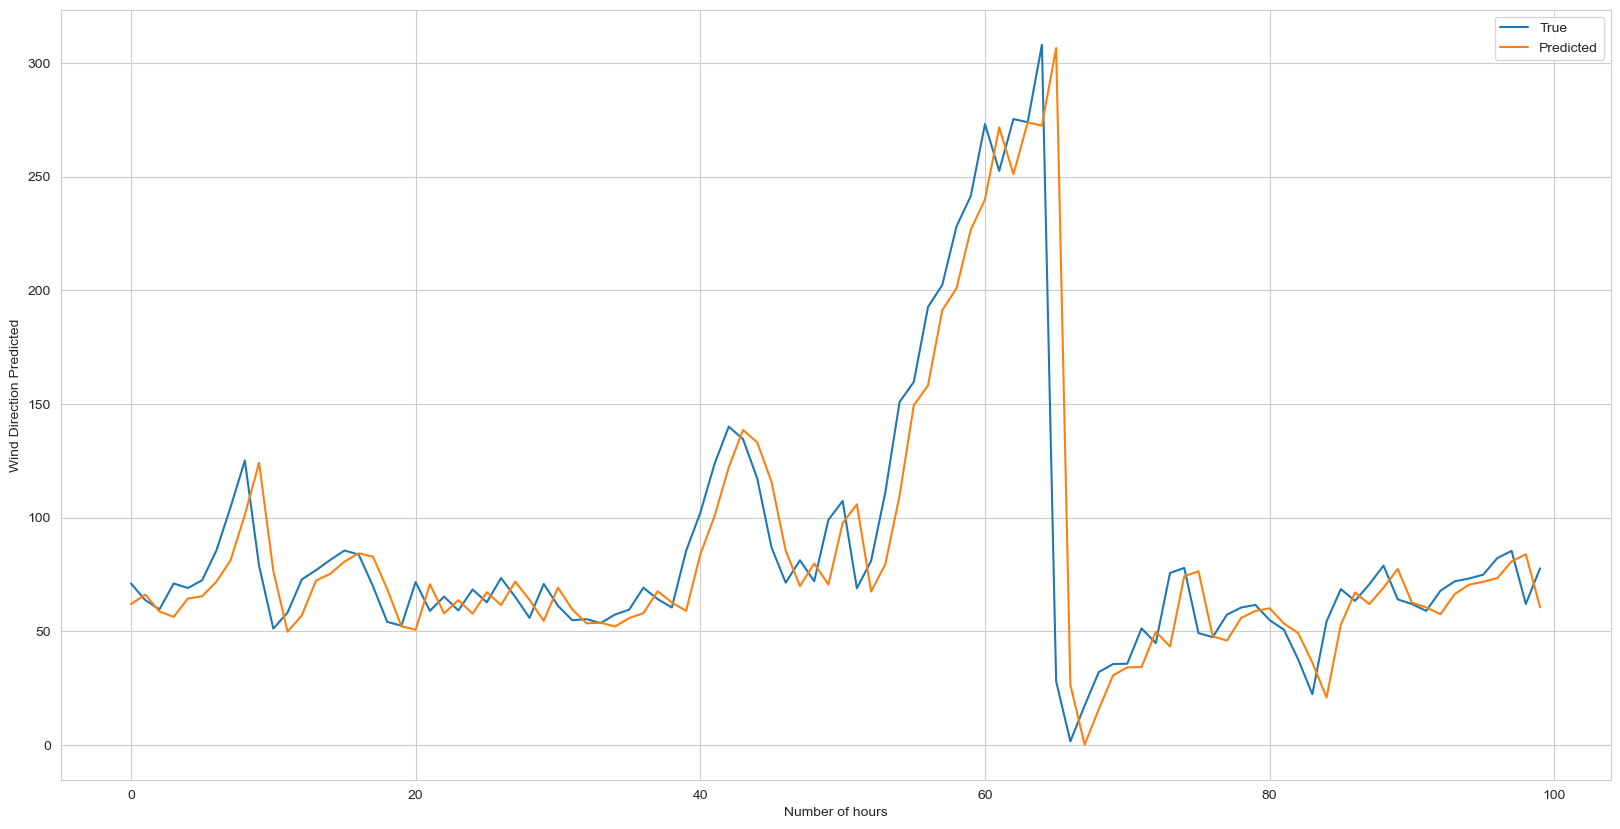

In [32]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(20,10))
pyplot.plot(expectations_plot[0:100], label="True")
pyplot.plot(predictions_plot[0:100], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Wind Direction Predicted")
pyplot.show()

In [33]:
import pickle 

In [34]:
Pkl_Filename = "Forcasting_WindDirection(E).pkl" 

In [35]:
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lstm_model, file)

In [36]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

In [ ]:
predictions

In [ ]:
len(predictions)

In [ ]:
csv_file_path = 'DirectionPredicted.csv'

In [ ]:
np.savetxt(csv_file_path, predictions, delimiter=',')